# Assignment 2 - *Convolutional Autoencoders*


> **Team members**

*   Jannik Wirtz - i6292051 - jannik.wirtz@student.maastrichtuniversity.nl
*   Shyngyskhan Abilkassov - i6288304 - s.abilkassov@student.maastrichtuniversity.nl

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D, Reshape
from tensorflow.keras.regularizers import L2
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

In [2]:
# Create CAE Architecture
def buildModel(activation_function='relu', padding='same', kernel_sizes=(3,3), encoder_filters= (8, 12), decoder_filters =(12,3), pooling_type=None, pooling_kernel = (2,2), dilation_rate = (1,1), strides = (1,1), input_channel_num = 3, dense_latent_units=[256], conv_latent_channels=[]):

    input_shape = (32,32,input_channel_num) # 32 x 32 pixels with 3 color channels
    kernel_init = 'glorot_normal'

    model = Sequential() # using a sequential architecture

    # encoder layers
    for i in range(len(encoder_filters)):
        if i == 0:
            # input layer
            model.add(Conv2D(
                activation=activation_function,
                filters=encoder_filters[i],
                kernel_size=kernel_sizes,
                padding=padding,
                kernel_initializer=kernel_init,
                strides=strides,
                input_shape=input_shape))
        else:
            # Hidden Layers
            model.add(Conv2D(
                activation=activation_function,
                filters=encoder_filters[i],
                kernel_size=kernel_sizes,
                padding=padding,
                strides=strides,
                kernel_initializer=kernel_init))

        # pooling
        if pooling_type is not None:
            model.add(pooling_type(pooling_kernel))


    assert len(dense_latent_units) == 0 and len(conv_latent_channels) != 0  \
        or len(dense_latent_units) != 0 and len(conv_latent_channels) == 0, \
          "please specify exactly one latent space type"

    # dense latent-space
    if len(dense_latent_units) != 0:
        # output shape of previous conv2d layer
        shape = model.layers[-1].output_shape
        # vectorize the Conv2D output for upcoming dense layer
        model.add(Flatten())

        for units in dense_latent_units:
            model.add(Dense(units))

        # size up again
        model.add(Dense(shape[1]*shape[2]*shape[3]))

        # reshape back to the Conv2D shape for upcoming Conv2DTranspose
        model.add(Reshape((shape[1], shape[2], shape[3])))

    # Conv2D latent space
    else:
        for channels in conv_latent_channels:
            model.add(Conv2D(
                filters=channels,
                kernel_size=kernel_sizes,
                padding=padding,
                kernel_initializer=kernel_init))


    # decoder layers
    for i in range(len(decoder_filters)):
        # Upsampling
        if pooling_type is not None:
            model.add(UpSampling2D(pooling_kernel))

        # transposed Conv. layer
        if i == len(decoder_filters)-1:
            model.add(Conv2DTranspose(
                activation='sigmoid',
                filters=decoder_filters[i],
                kernel_size=kernel_sizes,
                padding=padding,
                strides=strides,
                kernel_initializer=kernel_init))
        else:
            model.add(Conv2DTranspose(
                activation=activation_function,
                filters=decoder_filters[i],
                kernel_size=kernel_sizes,
                padding=padding,
                strides=strides,
                kernel_initializer=kernel_init))

    return model

In [3]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    """
    return np.expand_dims(np.dot(rgb[...,:3], [0.299, 0.587, 0.114]),-1)

In [4]:
def training_validation_graphs(history, color, model_name='', skip=1):
    fontsize = 10
    plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
    plt.rc('axes', labelsize=fontsize)     # fontsize of the axes title
    plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
    plt.rc('legend', fontsize=fontsize)    # legend fontsize
    loss = history.history['loss'][skip:]
    val_loss = history.history['val_loss'][skip:]
    epochs = range(skip+1, len(loss)+skip + 1)
    #plt.clf()

    plt.plot(epochs, loss, color=color, linestyle='dotted', label=model_name+' In-Sample MSE')
    plt.plot(epochs, val_loss, color=color, label=model_name+' Out-of-Sample MSE')
    plt.title('Learning curves')

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


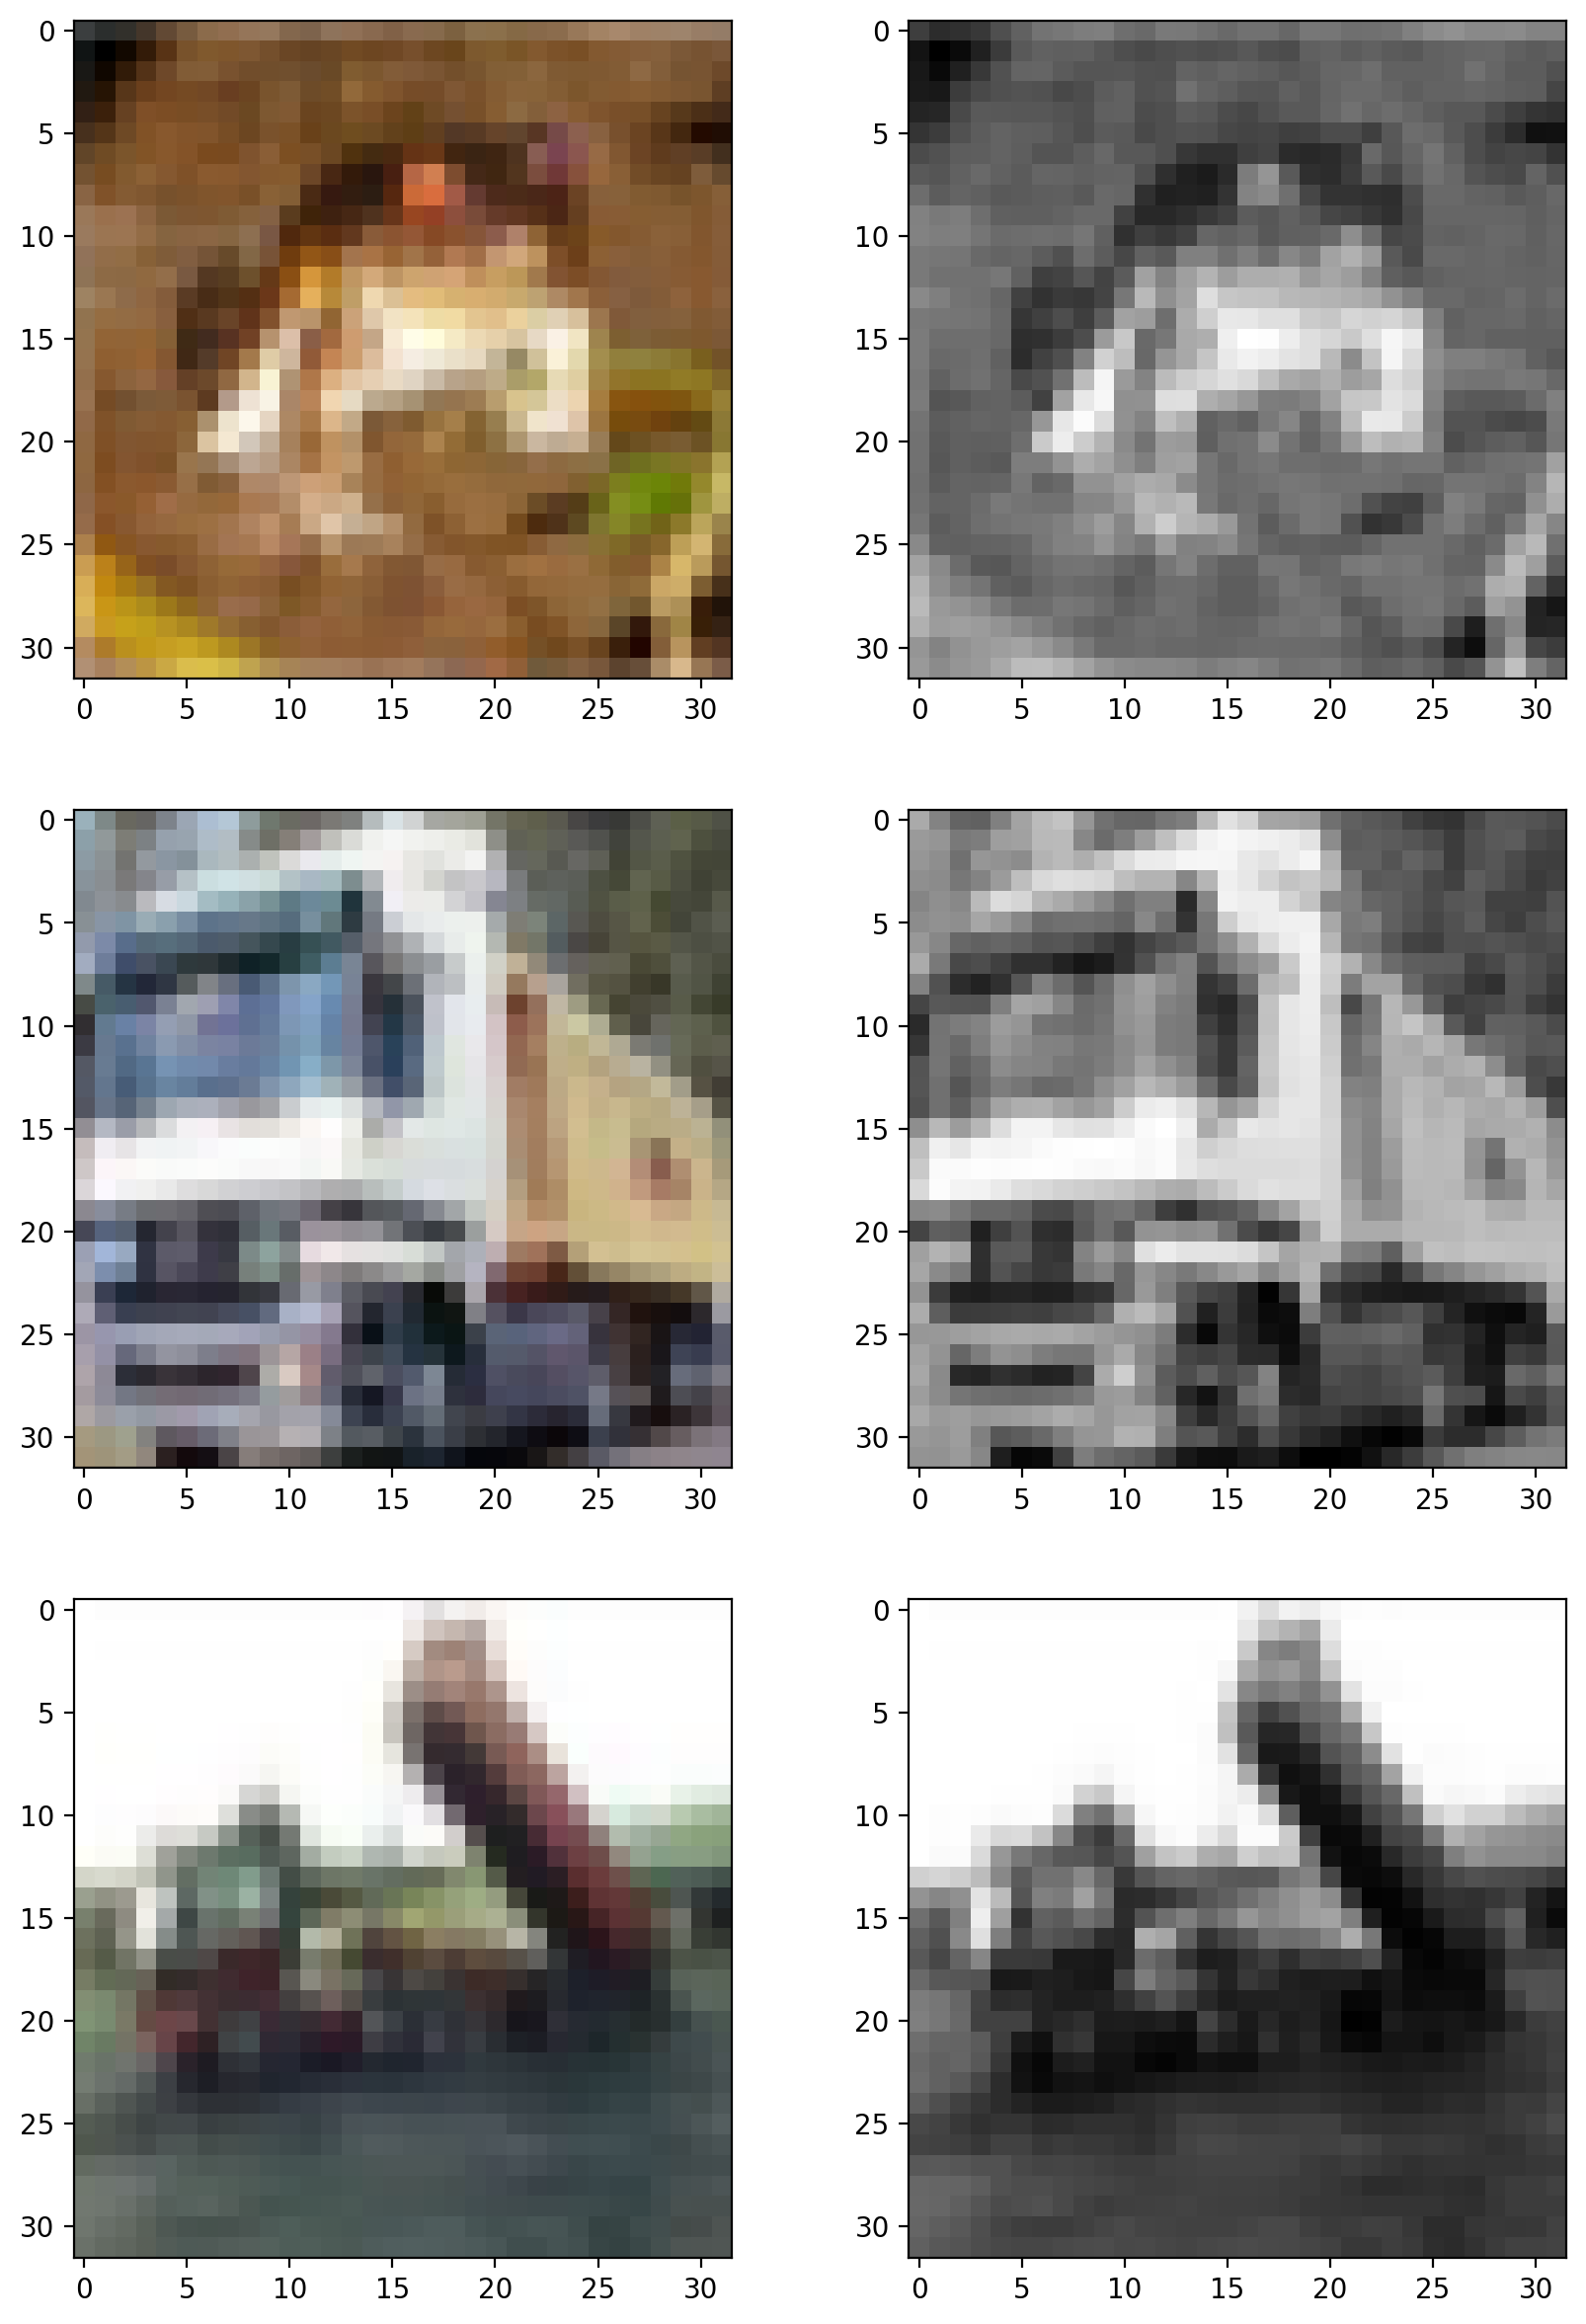

In [5]:
# load CIFAR-10 data
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data() # no need for labels

# normalize data
x = np.vstack((x_train, x_test))
x = x / 255

# split into 80/10/10 sets
(x_train, x_val, x_test) = np.vsplit(x, np.array([48000, 54000]))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

# produce grayscale images..
x_train_gray = rgb2gray(x_train)
x_val_gray = rgb2gray(x_val)
x_test_gray = rgb2gray(x_test)

# show sample images
fig, axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):
    axs[i][0].imshow(x_train[i])
    axs[i][1].imshow(np.squeeze(x_train_gray[i]), cmap='gray')


batch_size = 32

In [6]:
# build CAE with default configuration
model = buildModel(encoder_filters=(8, 12),
                   conv_latent_channels=[16],
                   decoder_filters=(12, 3),
                   dense_latent_units=[],
                   pooling_type=MaxPooling2D,
                   kernel_sizes=(3,3))
print(model.summary())

# define optimizer
model.compile(tf.keras.optimizers.Adam(), loss ='mse')

# train
batch_size = 32
epochs = 20
history = model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_val, x_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 12)        1

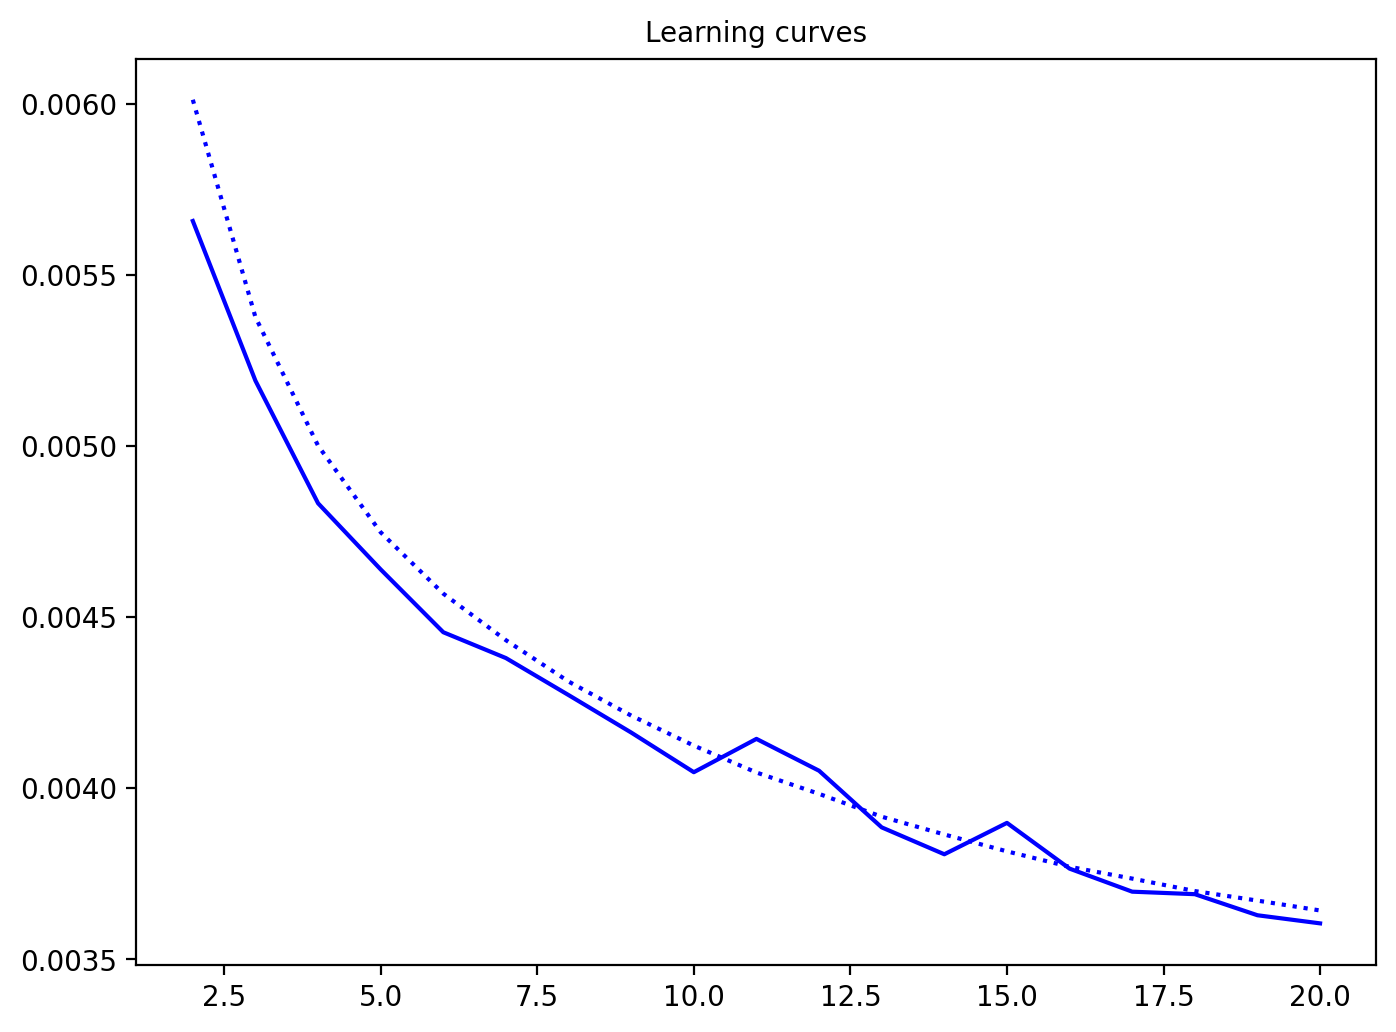

In [7]:
# plot evolution of error per epoch, include test error
training_validation_graphs(history, color='b')

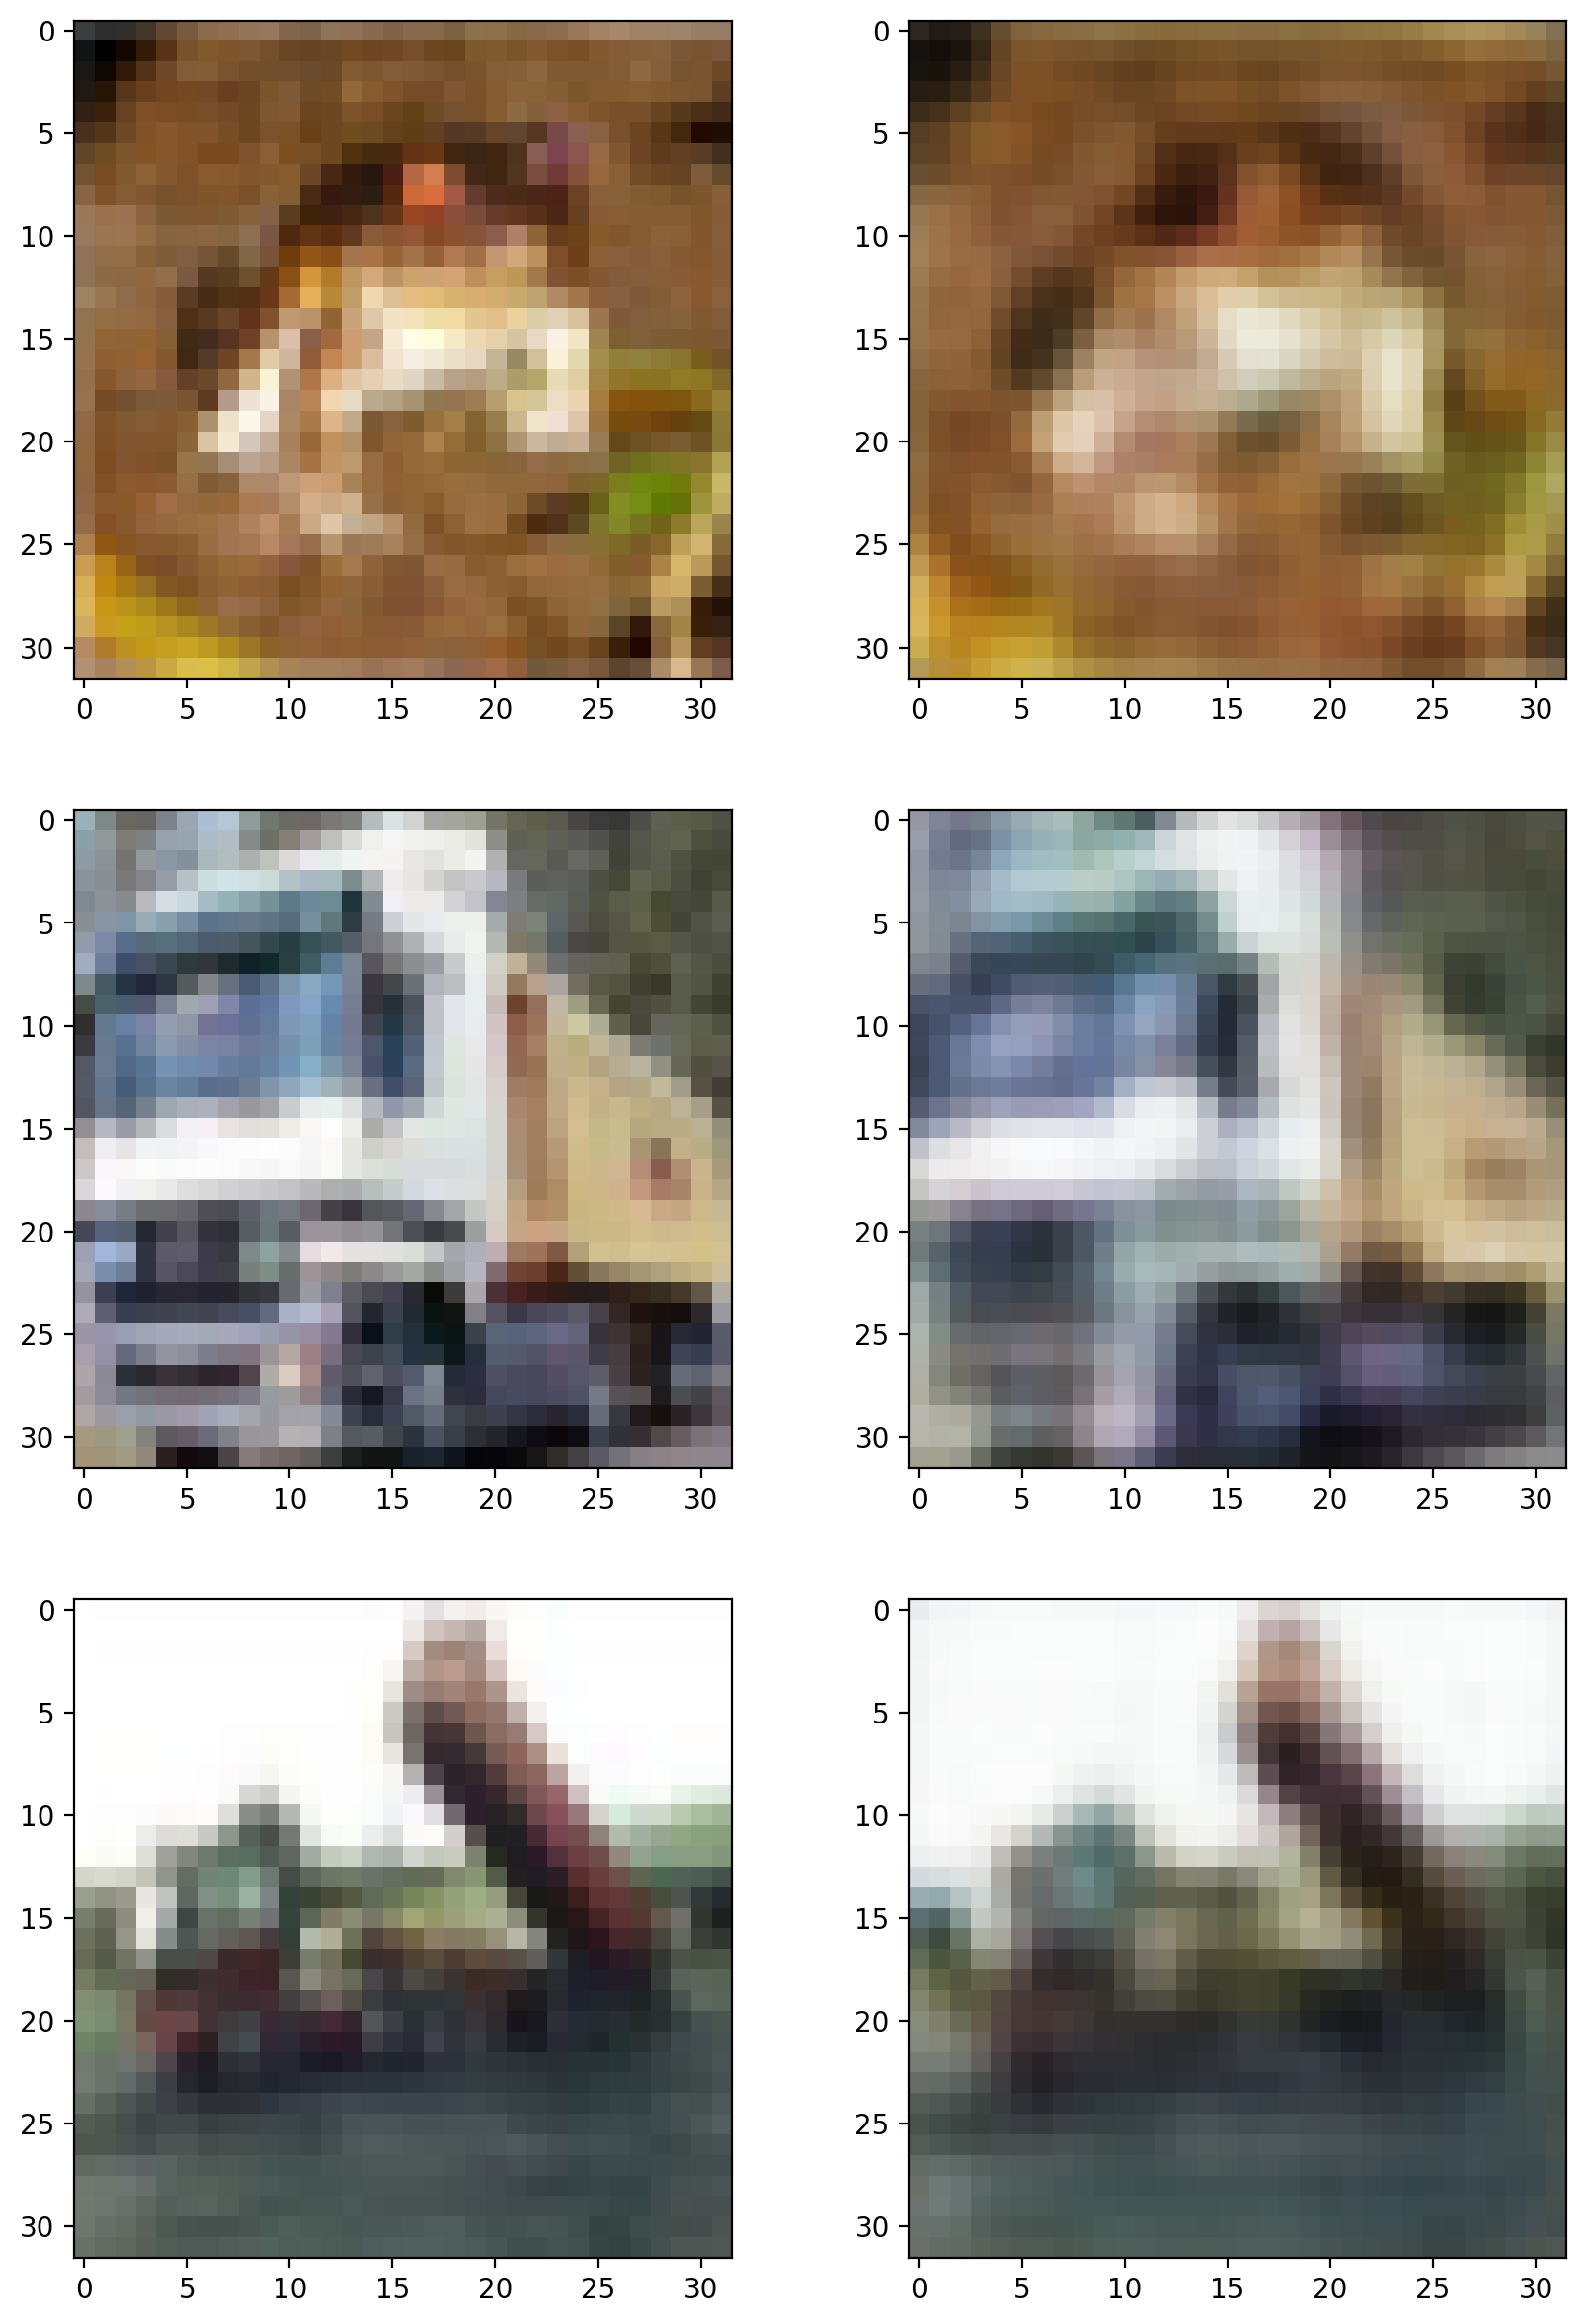

In [8]:
fig, axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):
    sample1 = x_train[i]
    axs[i][0].imshow(sample1)
    axs[i][1].imshow(model.predict(np.expand_dims(sample1,0))[0])

# Reconstruction

### 1. Size of the latent space

The Input Volume of the latent space is smaller compared to the first Convolutional layer due to the two pooling layers inbetween, which each halve the dimension of the input on every axis.



W = 8\
K = 3\
P = 1\
S = 1\
C = 16

-> Size = 1024

This is exactly the size of our input images (32x32x1 = 1024).



### 2. Neural Architecture and hyperparameter experiments
#### 2.1 Neural Architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 12)        876       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        1744      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 12)        1740      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 3)         327       
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 7.7179e-04
Epoch 2

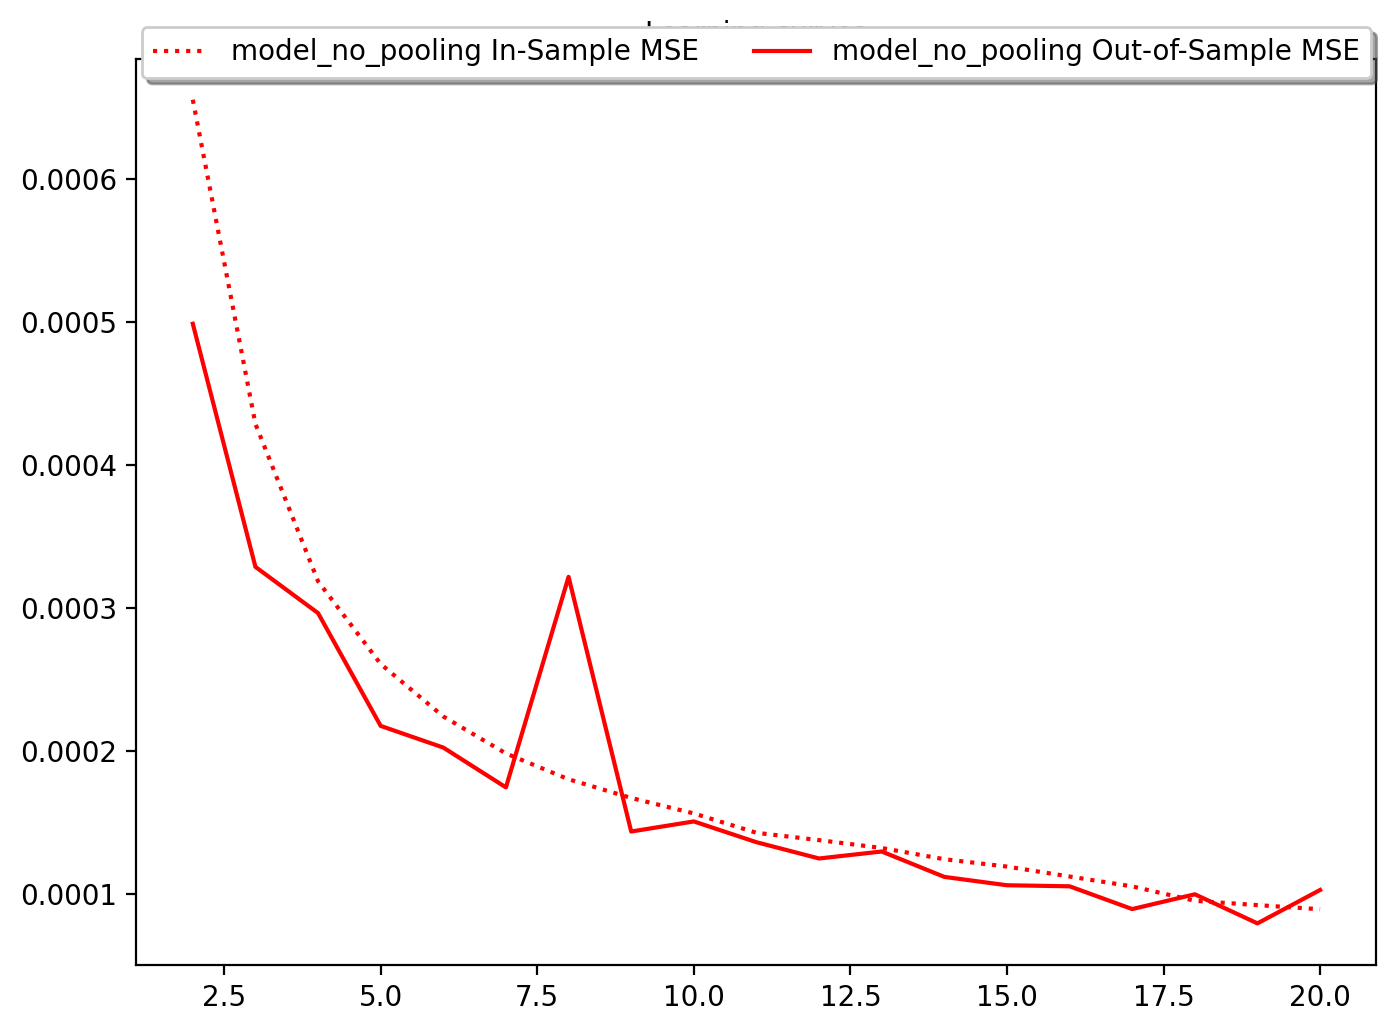

In [9]:
# Max pooling versus no-pooling
model_no_pooling = buildModel(dense_latent_units=[],
                   conv_latent_channels=[16],
                   pooling_type=None,
                   kernel_sizes=3)

print(model_no_pooling.summary())

# define optimizer
model_no_pooling.compile(tf.keras.optimizers.Adam(), loss = 'mse')

# train
history_no_pooling = model_no_pooling.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test, x_test))


# plot evolution of error per epoch, include test error
training_validation_graphs(history_no_pooling, color='r', model_name=str('model_no_pooling'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

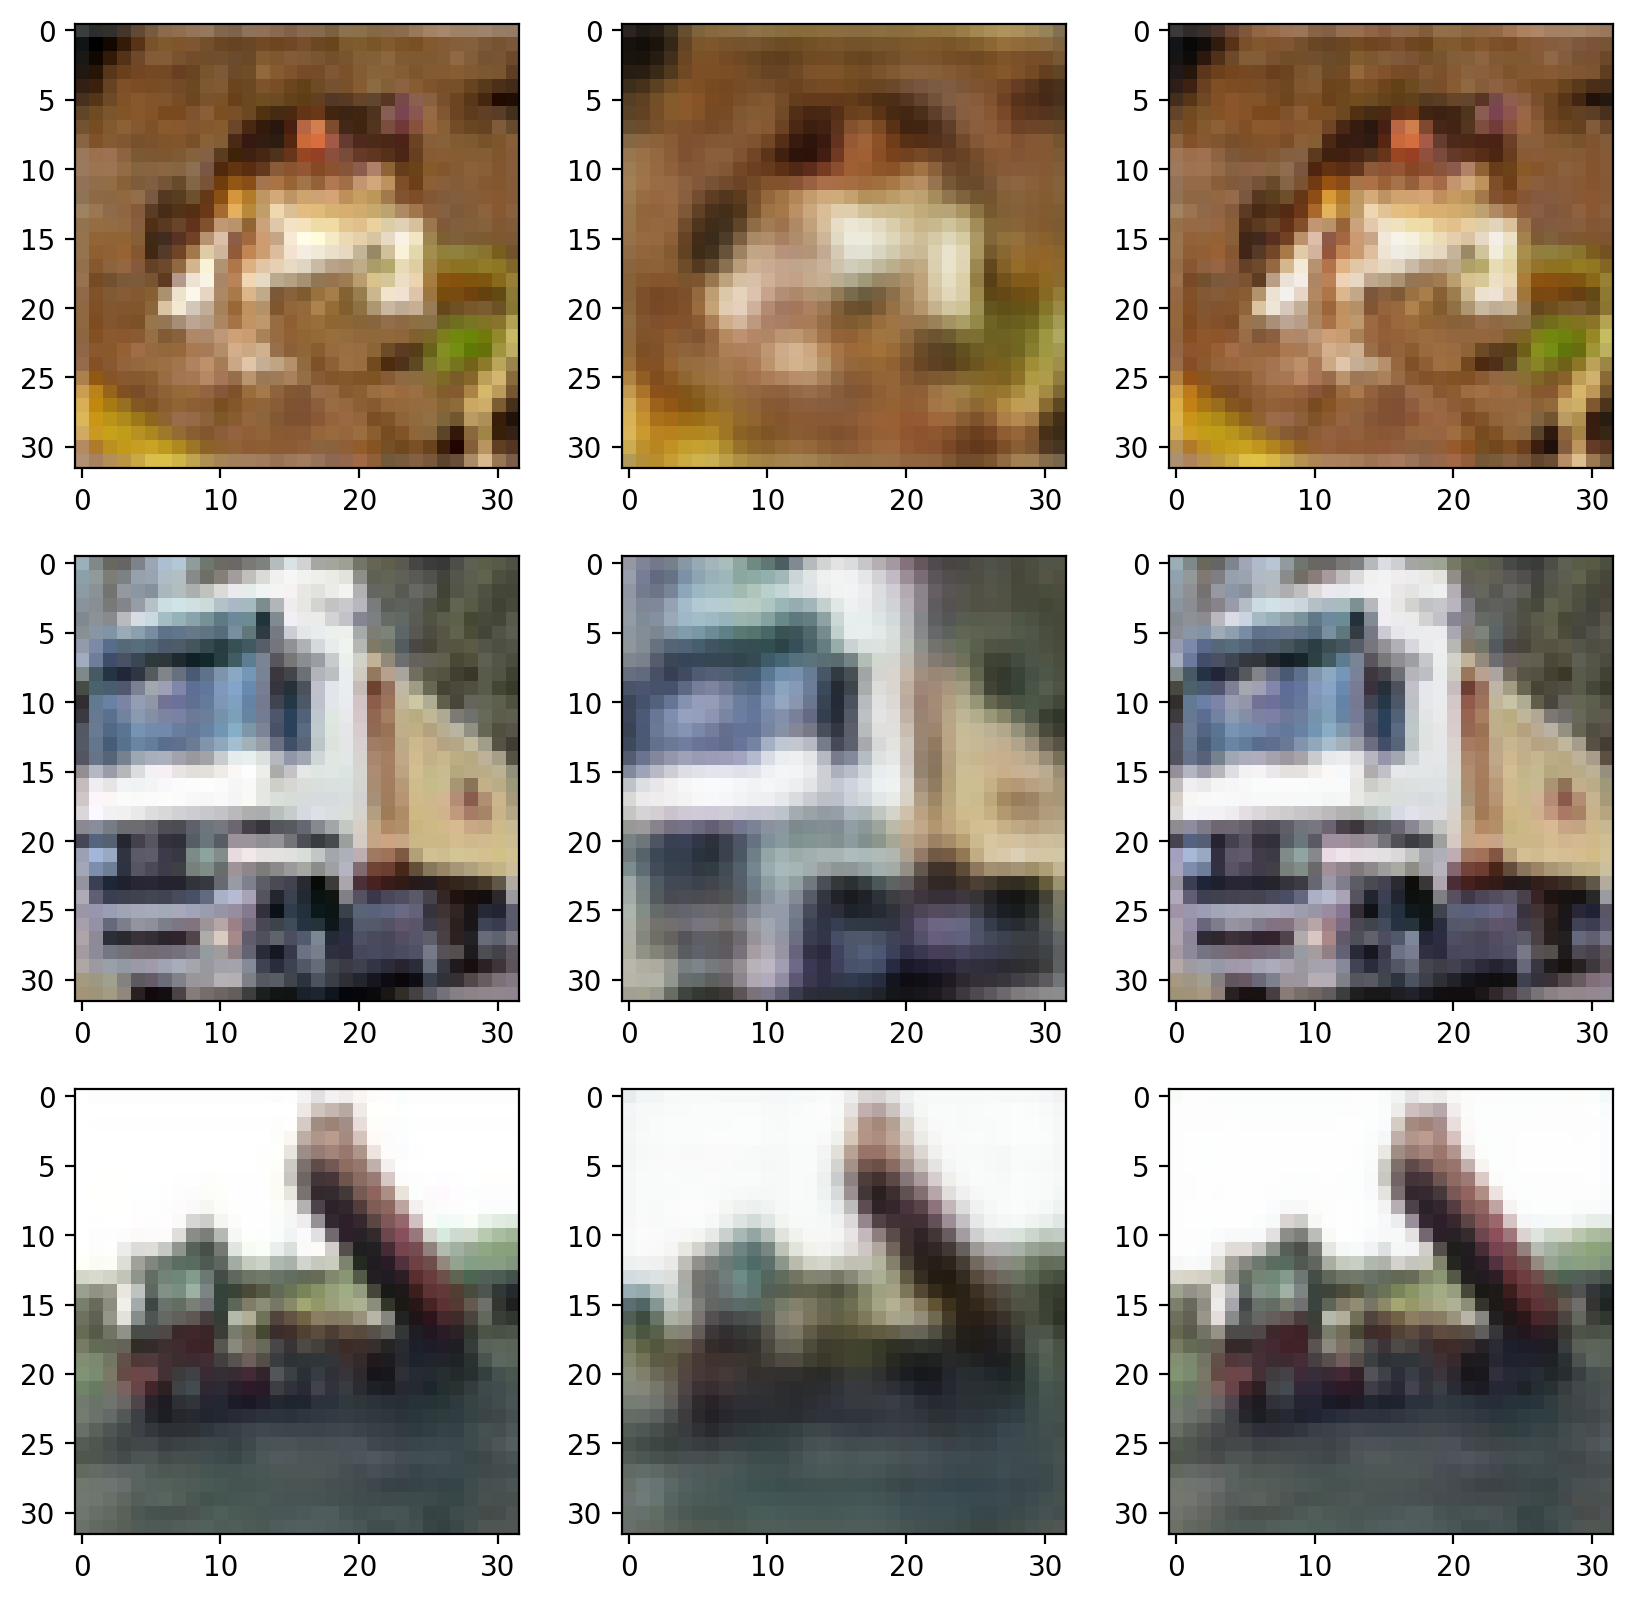

In [10]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    sample = x_train[i]
    axs[i][0].imshow(sample)
    axs[i][1].imshow(model.predict(np.expand_dims(sample,0))[0])
    axs[i][2].imshow(model_no_pooling.predict(np.expand_dims(sample,0))[0])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 12)          876       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 12)        1740      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         327       
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0195 - val_loss: 0.0050
Epoch 2/20


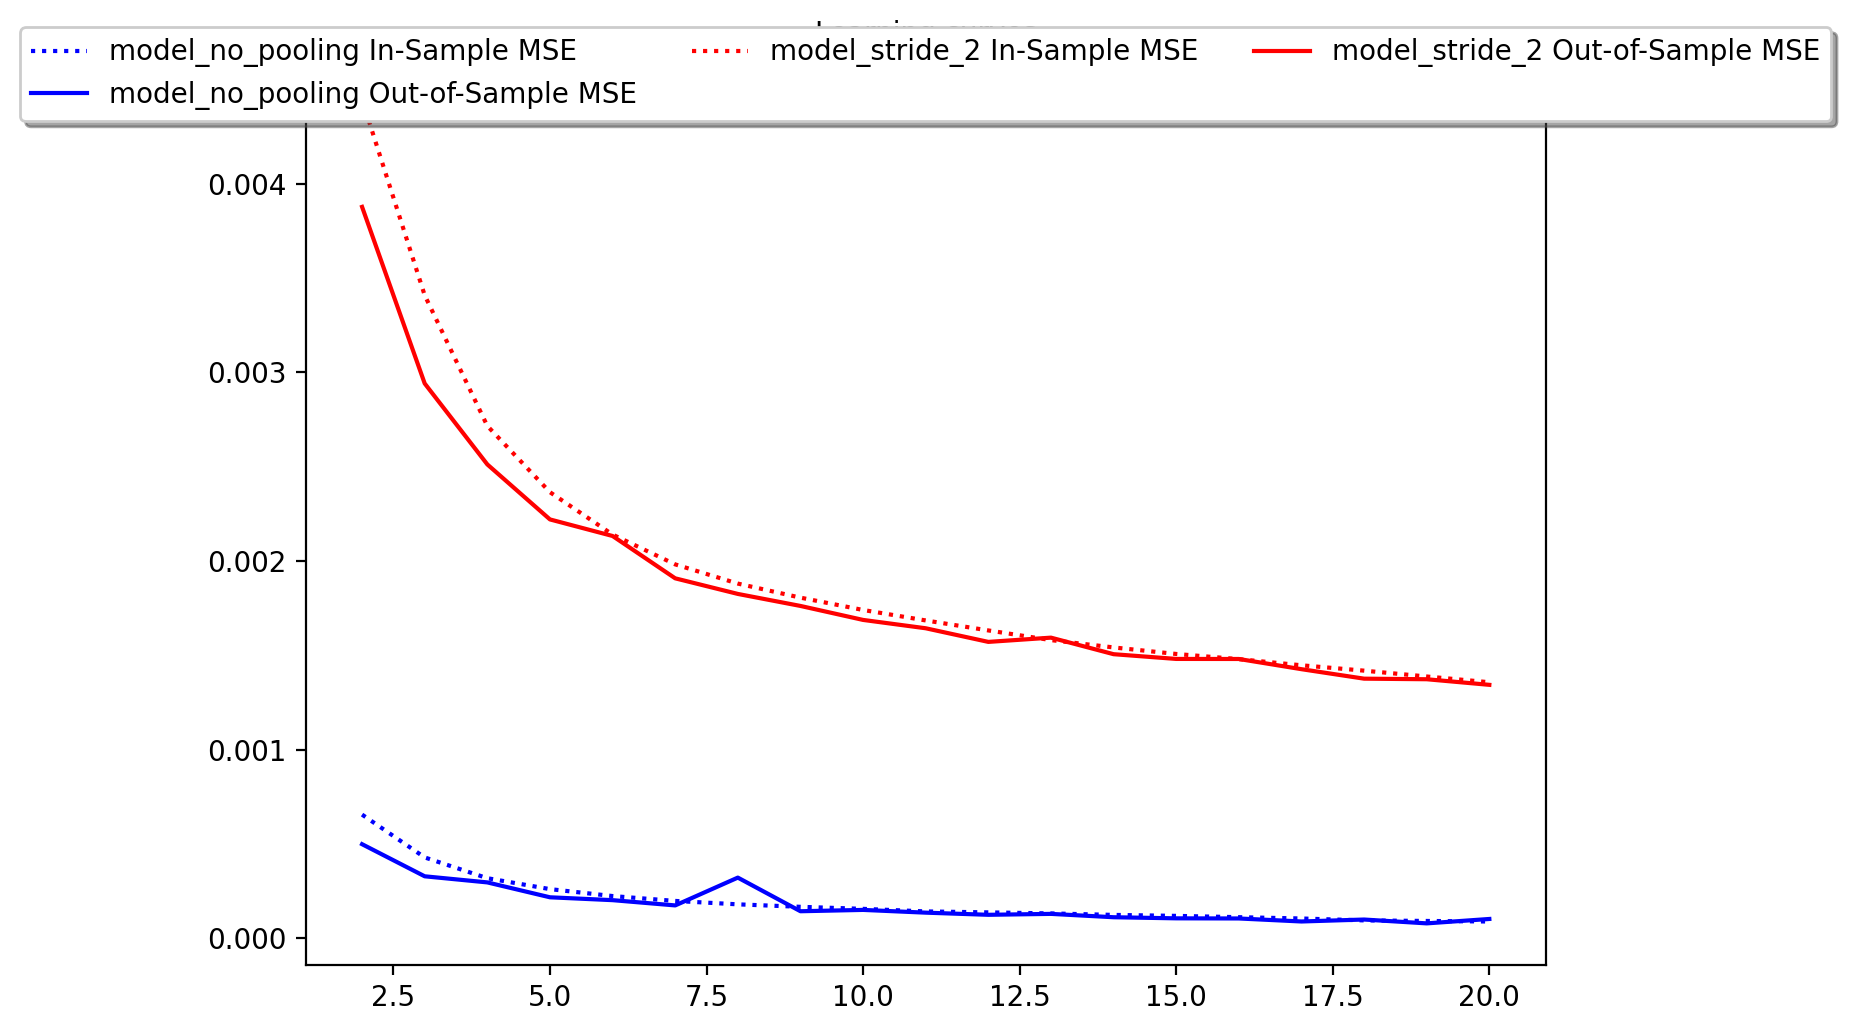

In [11]:
# Trying with stride of 2 for conv layers versus stride of 1
model_stride_2 = buildModel(
                    conv_latent_channels=[16],
                    dense_latent_units=[],
                    pooling_type=None,
                    strides=(2,2),
                    kernel_sizes=3)

print(model_stride_2.summary())

# define optimizer
model_stride_2.compile(tf.keras.optimizers.Adam(), loss = 'mse')

# train
history_stride_2 = model_stride_2.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test, x_test))


# plot evolution of error per epoch, include test error
training_validation_graphs(history_no_pooling, color='b', model_name=str('model_no_pooling'))
training_validation_graphs(history_stride_2, color='r', model_name=str('model_stride_2'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

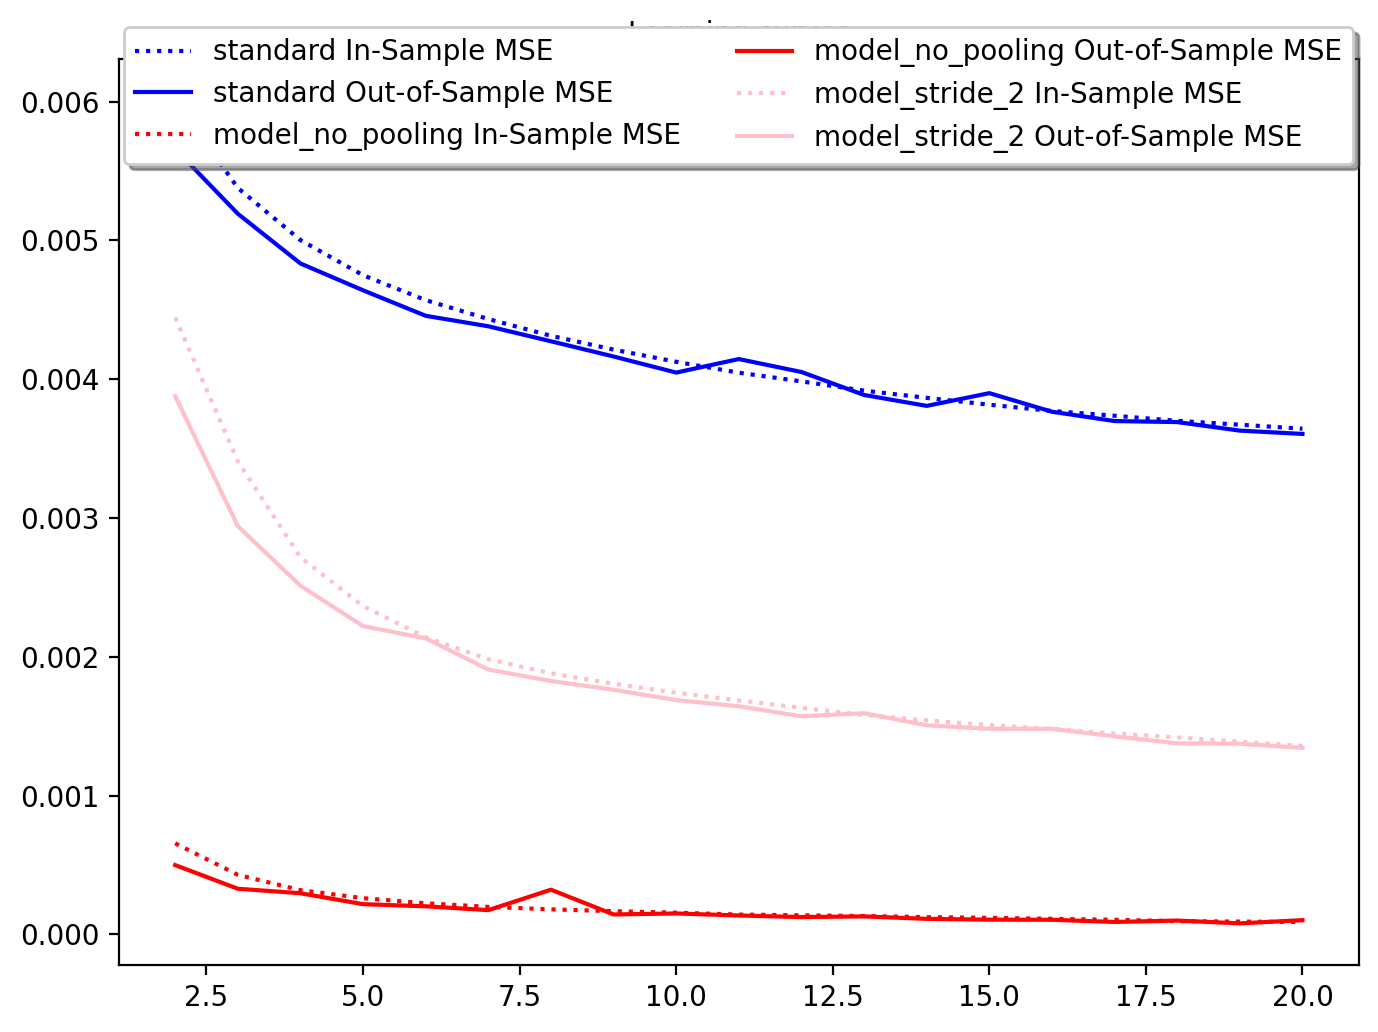

In [12]:
# plot evolution of error per epoch, include test error
training_validation_graphs(history, color='b', model_name=str('standard'))
training_validation_graphs(history_no_pooling, color='r', model_name=str('model_no_pooling'))
training_validation_graphs(history_stride_2, color='pink', model_name=str('model_stride_2'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)
# Stride of 2 leads to a worse model compared to the previous model (both use no pooling)

In [13]:
# higher filter counts and more decoder layers
encoder_filters = [(8, 12), (8, 12, 16), (8, 12, 16, 24)]
decoder_filters = [(12, 3), (16, 12, 3), (24, 16, 12, 3)]

P = np.zeros(shape=(len(encoder_filters),len(decoder_filters))) # for heatmap of gridsearch
epochs = 10
colors = ['b', 'r', 'green', 'pink', 'orange', 'black']
colors = colors[:len(decoder_filters)]

histories = []

for i, ef in enumerate(encoder_filters):
    for j, df in enumerate(decoder_filters):
        # build CAE
        model_more_layers = buildModel(encoder_filters=ef,
                                       decoder_filters=df,
                                       dense_latent_units=[],
                                       conv_latent_channels=[ef[-1]],
                                       pooling_type=None,
                                       kernel_sizes=(3,3))

        print(model_more_layers.summary())

        # define optimizer
        model_more_layers.compile(tf.keras.optimizers.Adam(), loss = 'mse')

        # train
        histories.append(model_more_layers.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test, x_test)))

history_more_layers = histories[-1]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 12)        876       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 12)        1308      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 12)        1308      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 3)         327       
Total params: 4,043
Trainable params: 4,043
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 9.5177e-04
Epoch 2

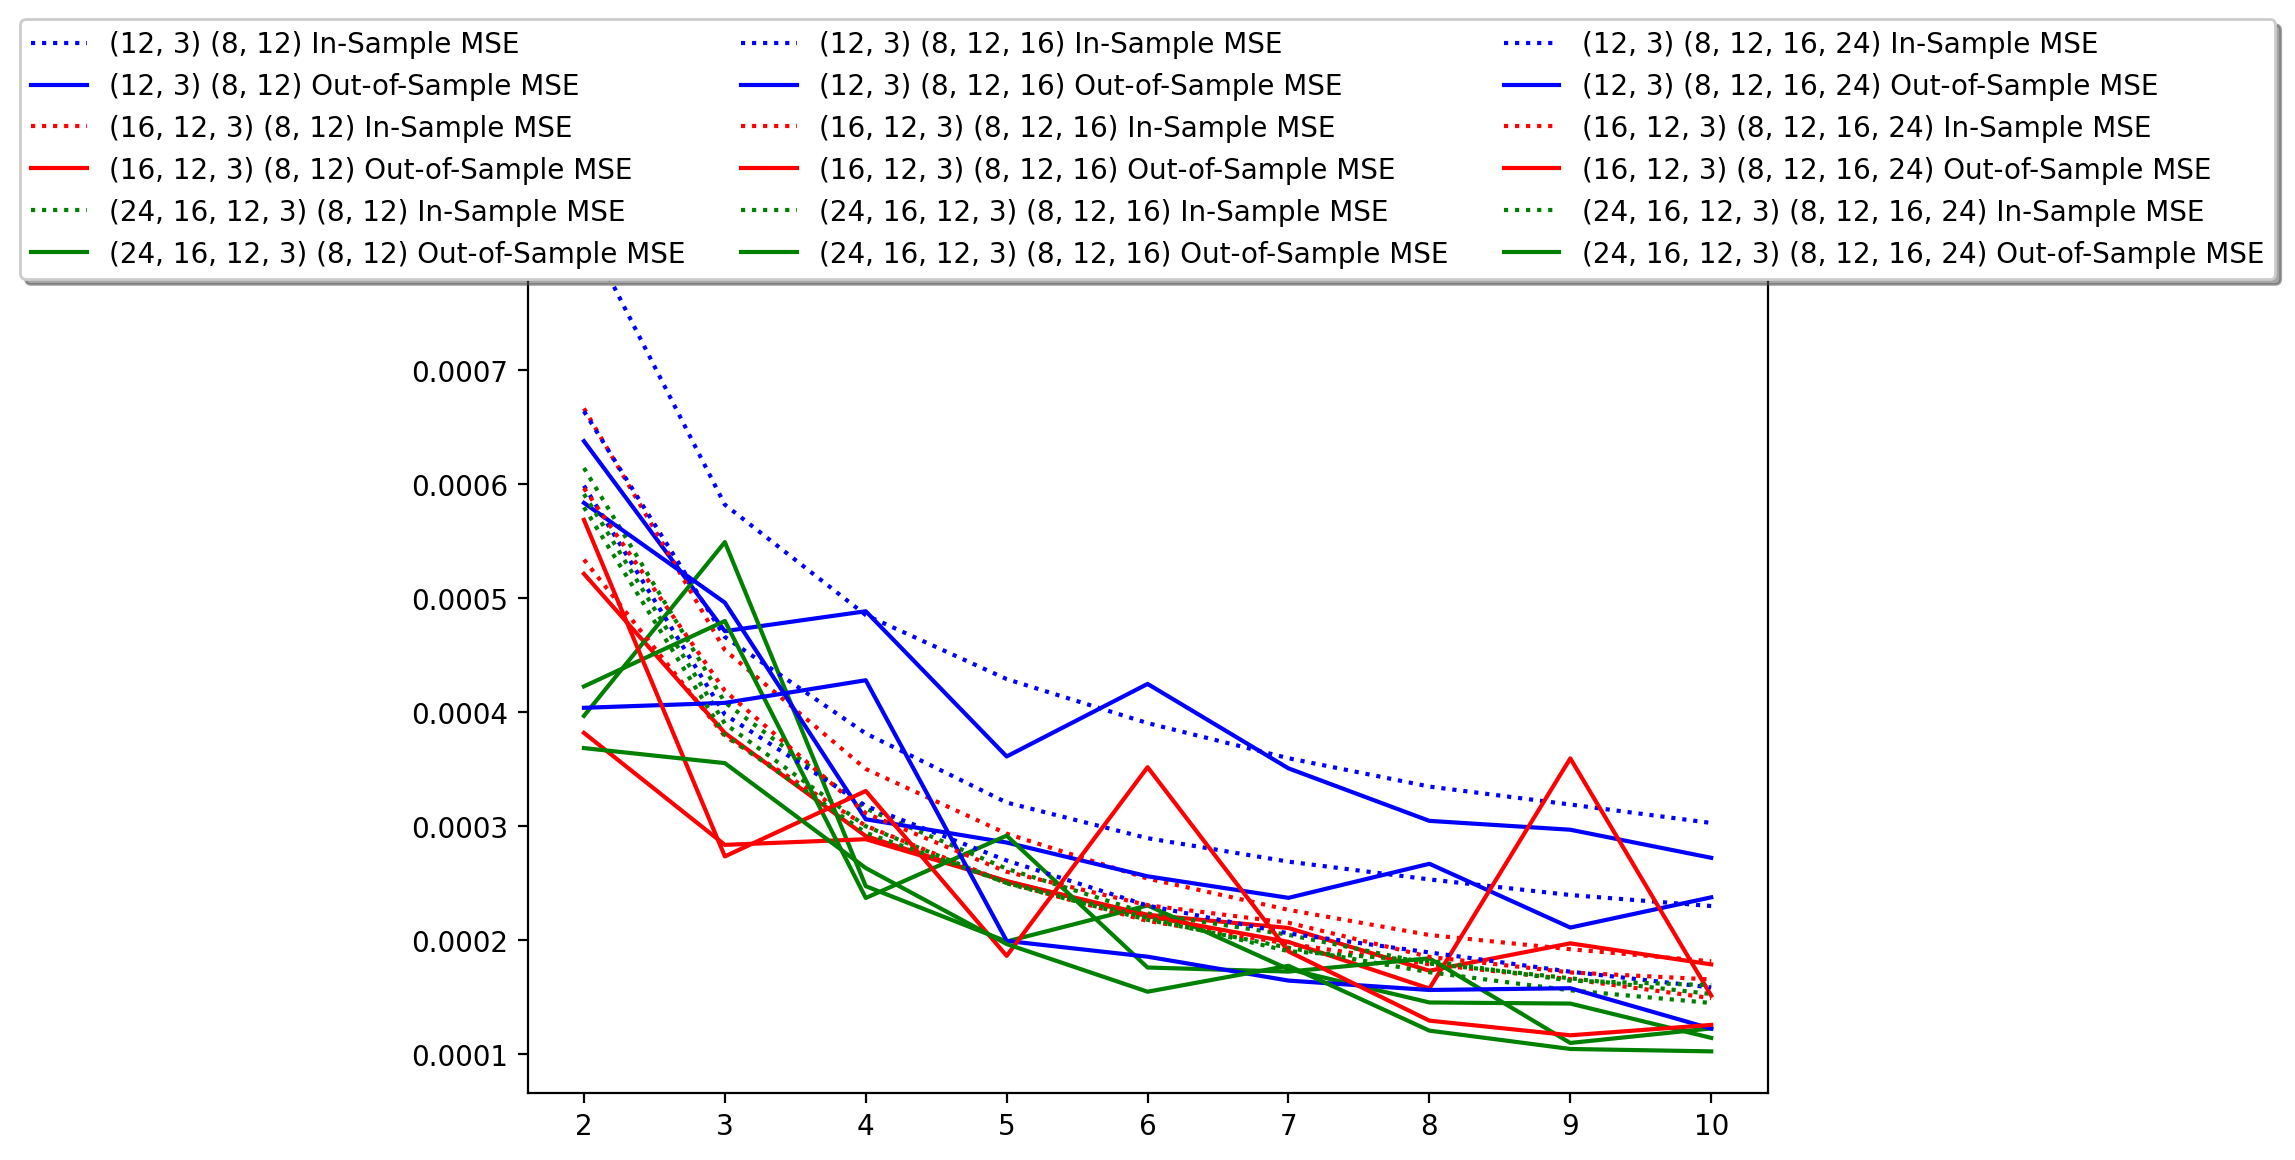

In [14]:
for i, ef in enumerate(encoder_filters):
    for j,ef in enumerate(decoder_filters):
        training_validation_graphs(histories[j+i*len(decoder_filters)], colors[j%len(colors)], model_name=str(decoder_filters[j])+' '+ str(encoder_filters[i]), skip =1)

        P[j][i] = histories[j+i*len(decoder_filters)].history['val_loss'][-1]
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
plt.show()

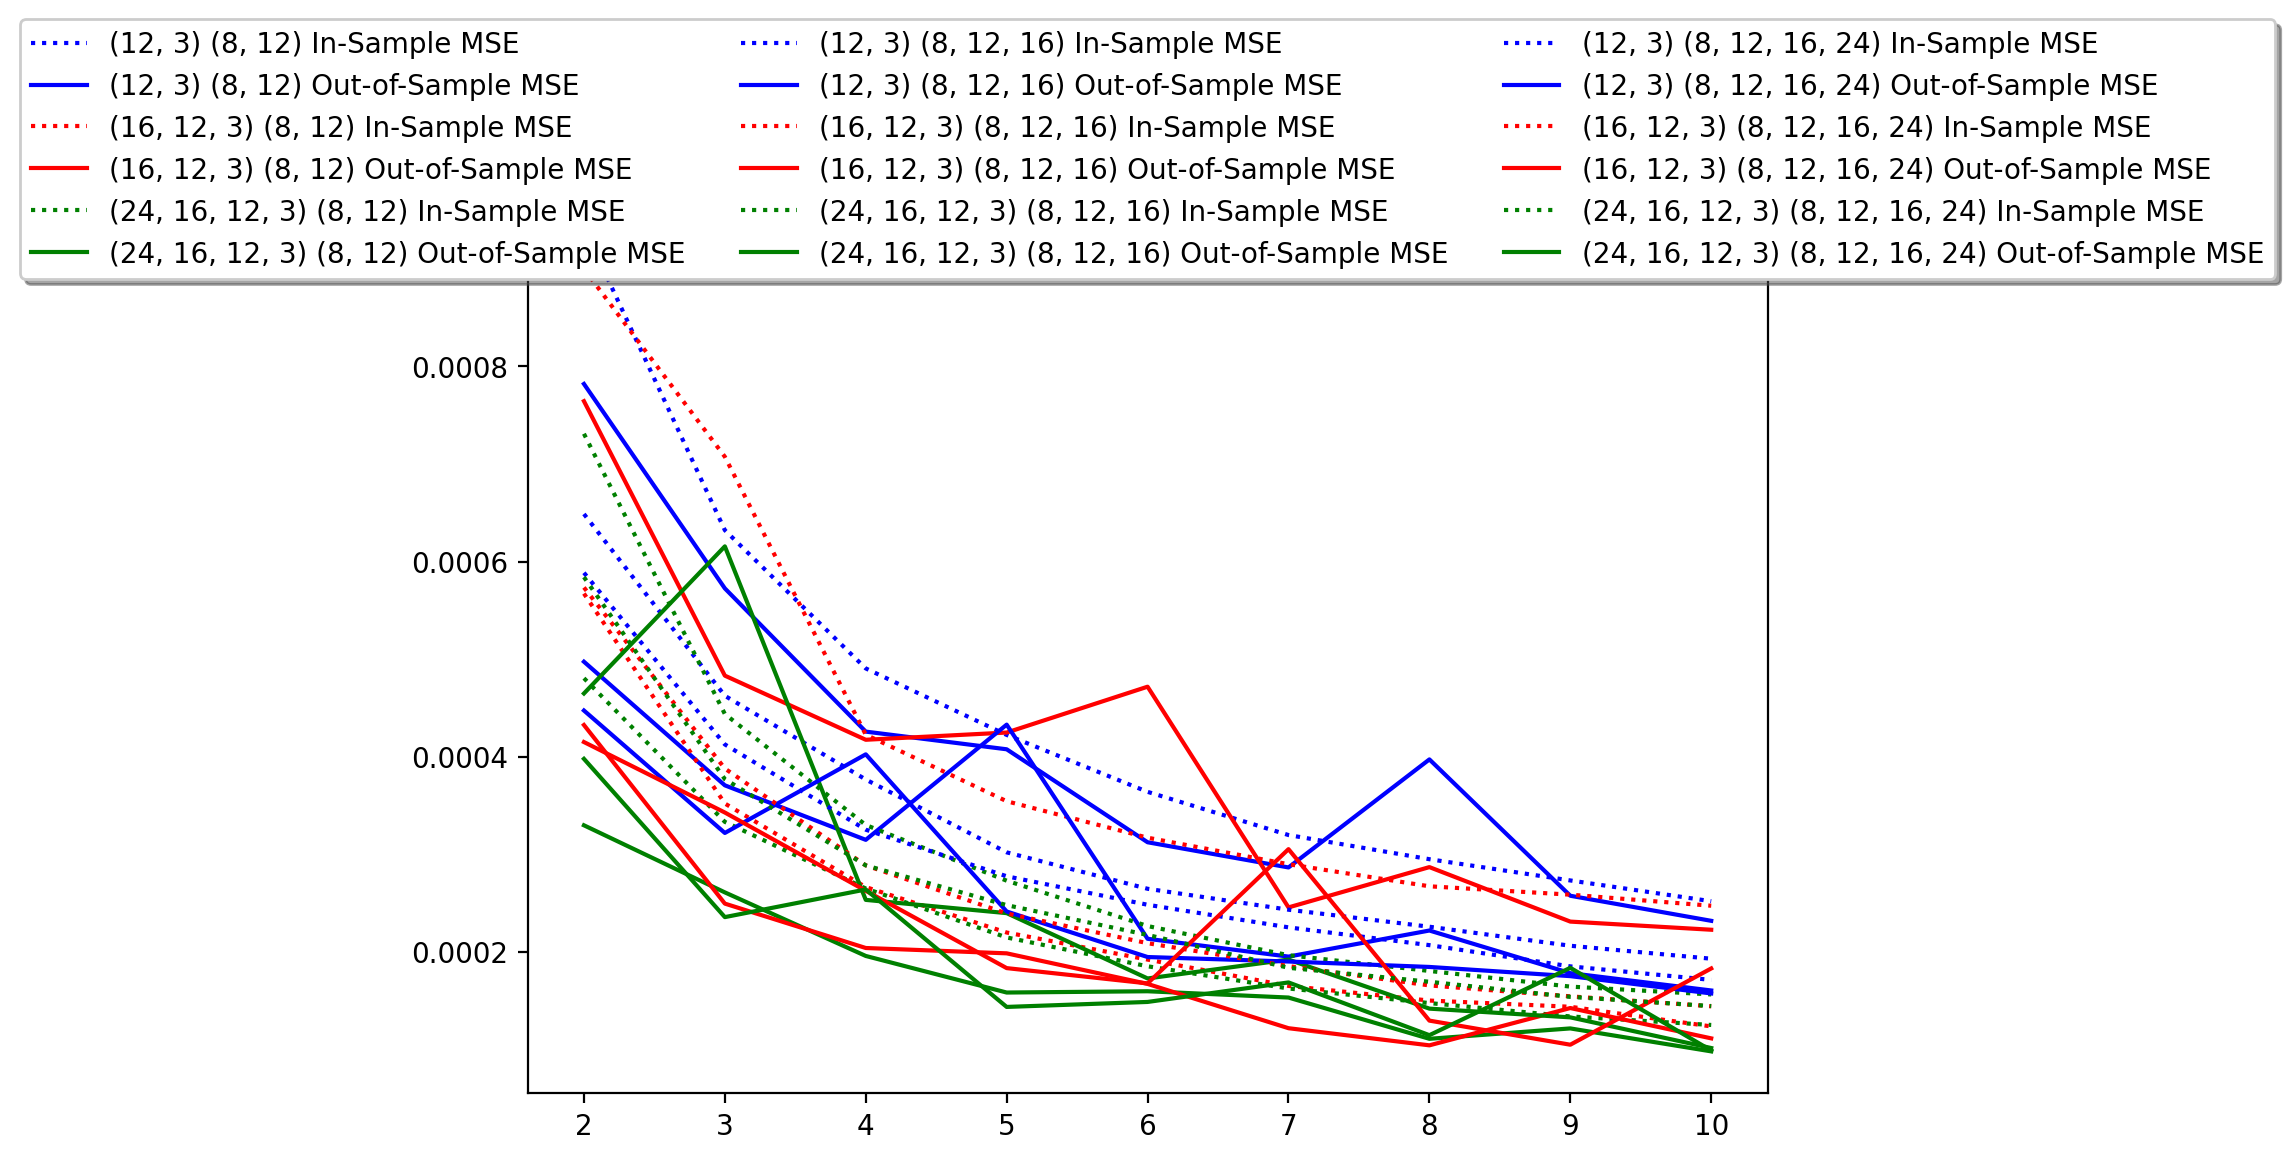

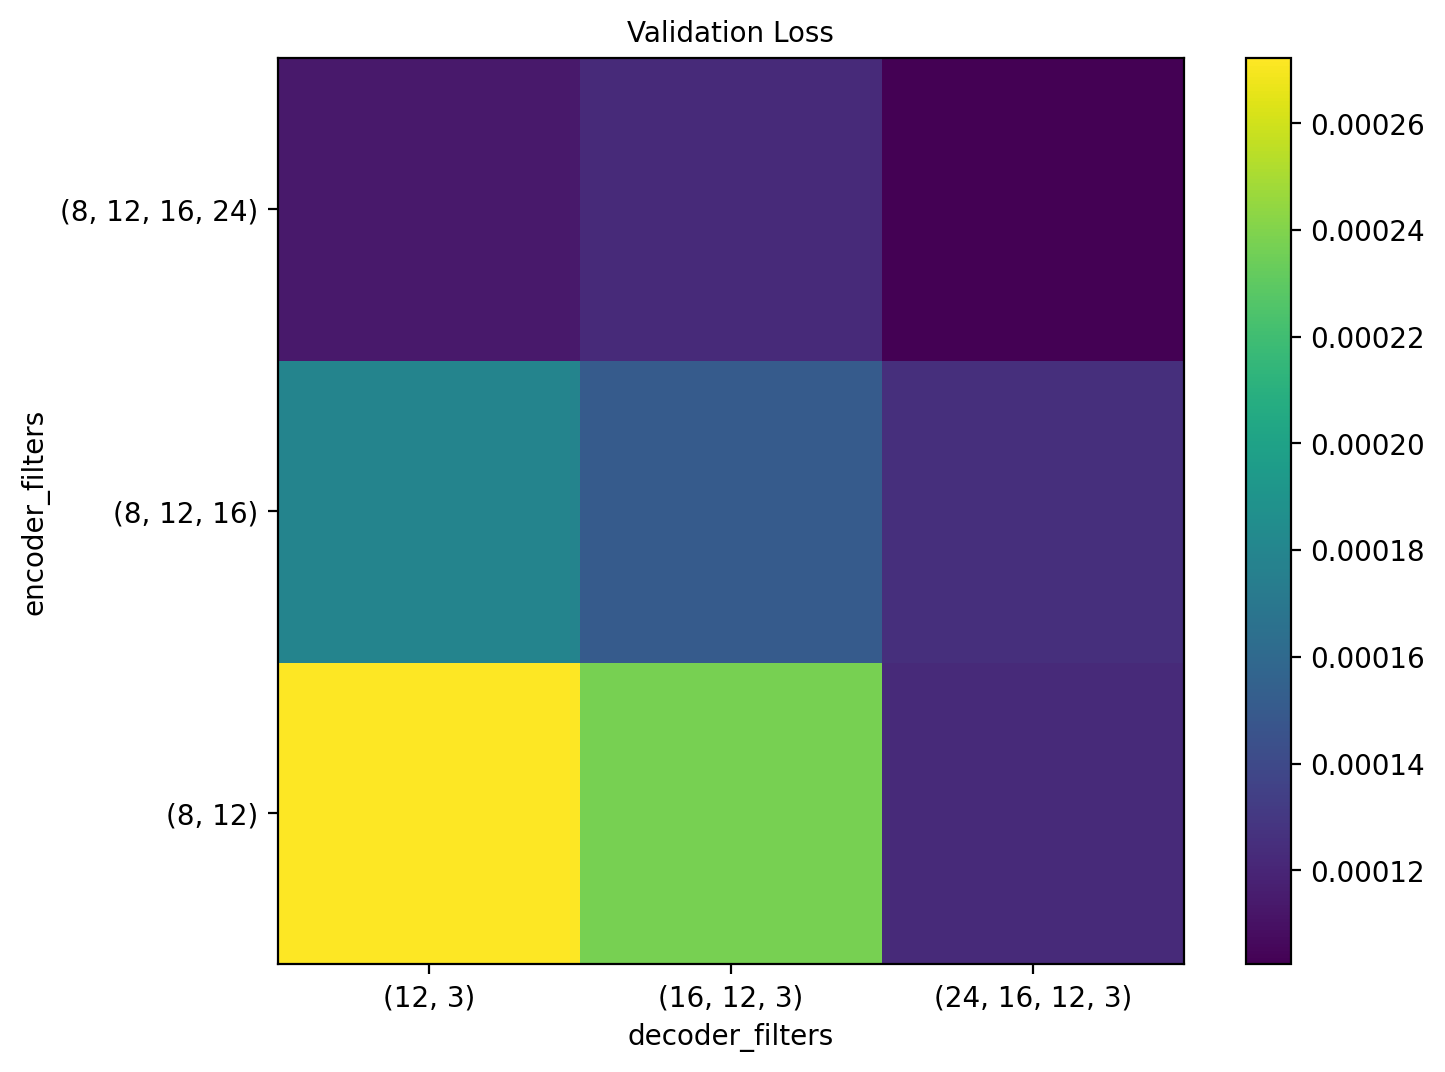

(2, 2)
[[0.00027217 0.00023749 0.00012228]
 [0.00017867 0.00015129 0.00012556]
 [0.0001142  0.00012251 0.00010236]]


In [15]:
# heat map plot
plt.imshow(P, origin='lower')
plt.colorbar()
plt.xticks(range(len(decoder_filters)), decoder_filters)
plt.yticks(range(len(encoder_filters)), encoder_filters)
plt.xlabel("decoder_filters")
plt.ylabel("encoder_filters")
plt.title("Validation Loss")
plt.show()
print(np.unravel_index(np.argmin(P), P.shape))
print(P)

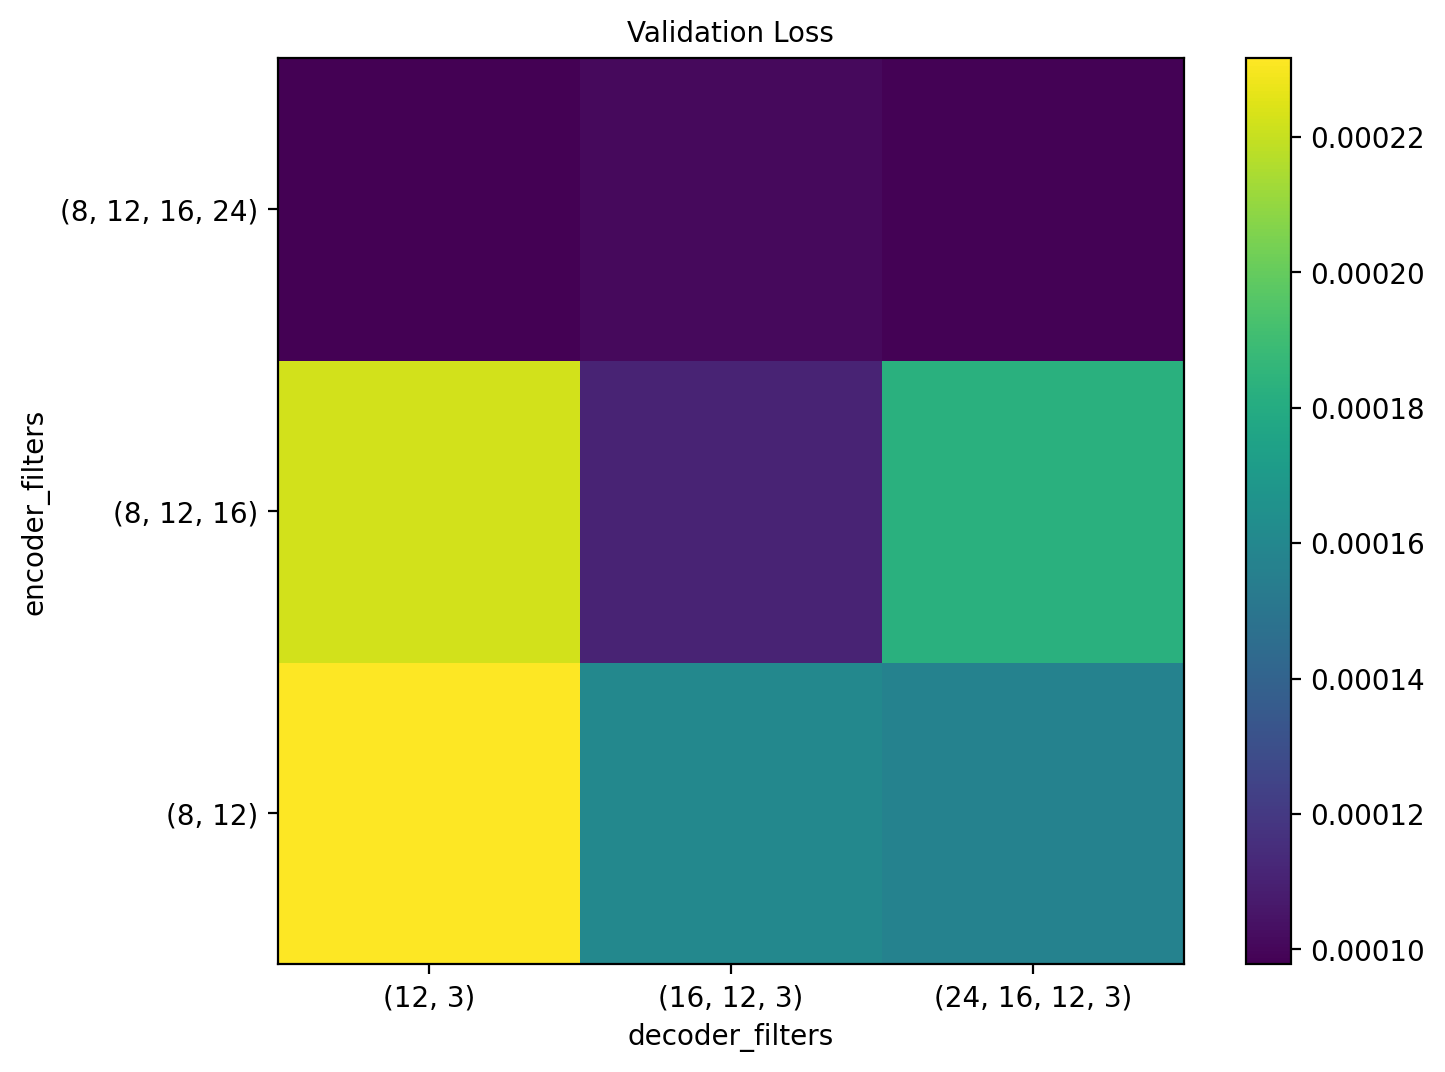

In [16]:
# Filter counts
initial_filtercount = [2, 4, 8, 16]
epochs = 10

histories = []

colors = ['b', 'r', 'green', 'pink', 'orange', 'black']
colors = colors[:len(initial_filtercount)]

for i, initial in enumerate(initial_filtercount):

    ef = [initial, 2**1*initial, 2**2*initial, 2**3*initial]
    df = ef[1:]
    df = df[::-1]
    df.append(3)

    # build CAE
    model = buildModel(encoder_filters=ef,
                        decoder_filters=df,
                        dense_latent_units=[],
                        conv_latent_channels=[ef[-1]],
                        pooling_type=None,
                        kernel_sizes=(3,3))

    print(model.summary())

    # define optimizer
    model.compile(tf.keras.optimizers.Adam(), loss = 'mse')

    # train
    histories.append(model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test, x_test)))

history_more_filters = histories[-1]

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 2)         56        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 4)         76        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 8)         296       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 32, 32, 8)       

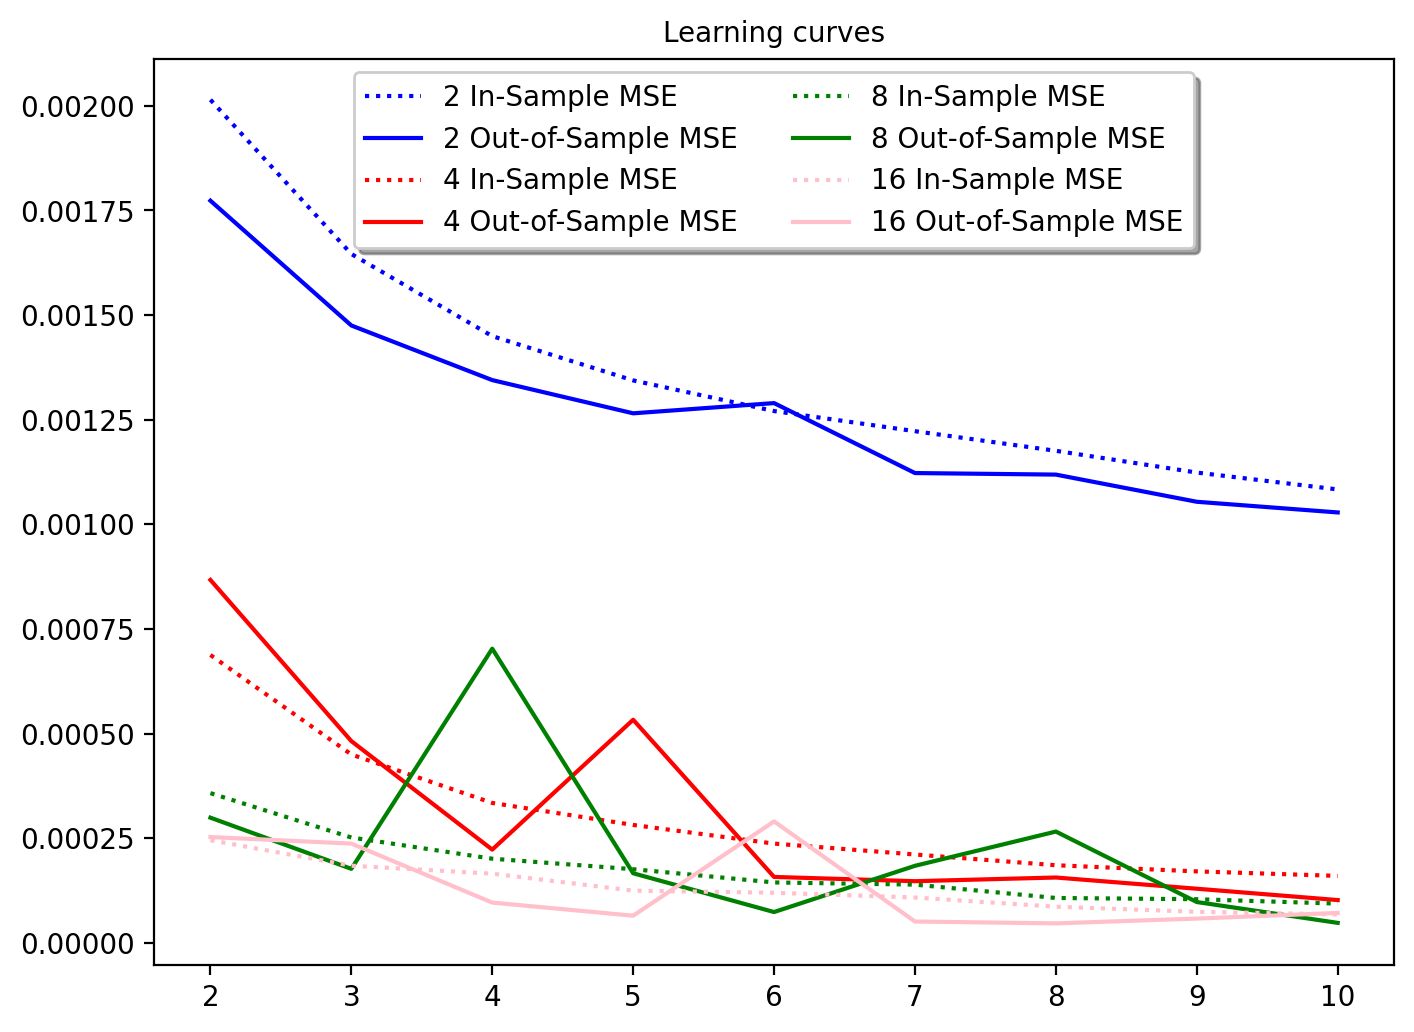

In [17]:
for i, initial in enumerate(initial_filtercount):
    training_validation_graphs(histories[i], colors[i%len(colors)], model_name=str(initial), skip = 1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=True)
plt.show()

In [18]:
# adding dense layers to latent space
# using suboptimal initial filter counts, due to hardware constraints
initial = 8
ef = [initial, 2**1*initial, 2**2*initial, 2**3*initial]
df = ef[1:]
df = df[::-1]
df.append(3)
epochs =10

# build CAE
model_dense_latent = buildModel(encoder_filters=ef,
                               decoder_filters=df,
                               dense_latent_units=[ef[-1]],
                               conv_latent_channels=[],
                               pooling_type=None,
                               kernel_sizes=(3,3))

print(model_dense_latent.summary())

# define optimizer
model_dense_latent.compile(tf.keras.optimizers.Adam(), loss = 'mse')

history_dense_latent = model_dense_latent.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test, x_test))


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 65536)           

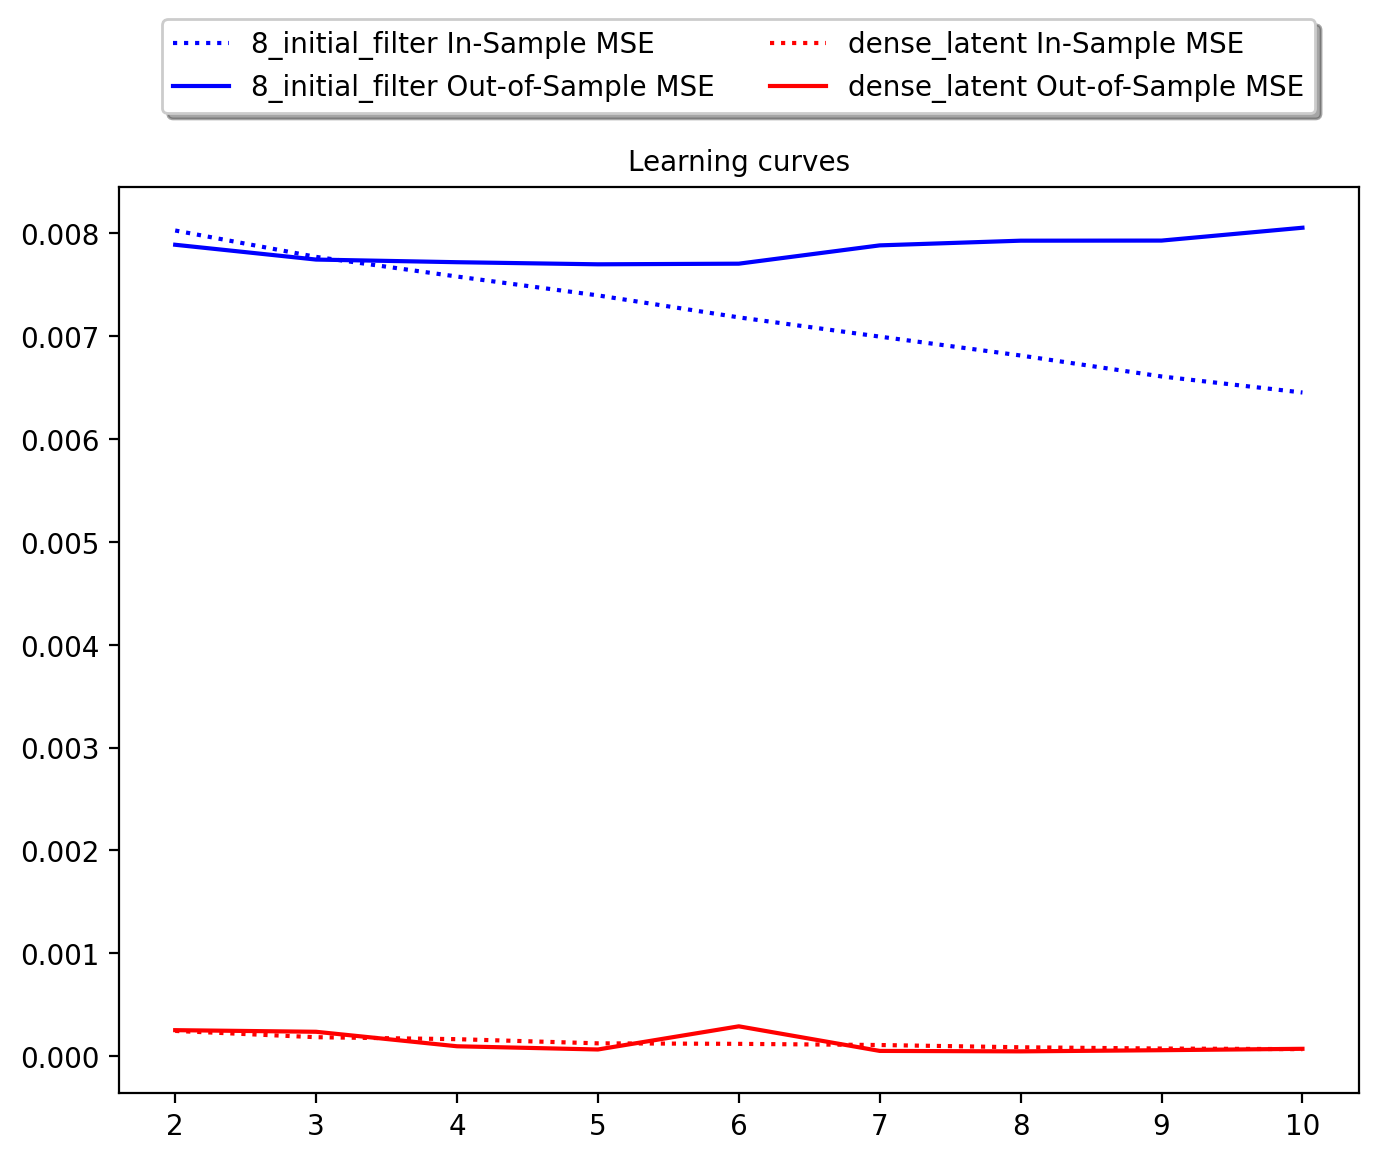

In [19]:
training_validation_graphs(history_dense_latent, 'b', model_name='8_initial_filter', skip = 1)
training_validation_graphs(history_more_filters, 'r', model_name='dense_latent', skip = 1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=True)
plt.show()

# Colorization

#### 1. Adapting Architecture for colorization



#### 2. Results, shortcomings and experiments for improved performance

In [32]:
# build CAE
model = buildModel(
    encoder_filters = (64, 128, 256),
    decoder_filters = (256,128,3),
    dense_latent_units = [256],
    kernel_sizes = 3,
    pooling_type = None,
    input_channel_num = 1)

print(model.summary())


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               67109120  
_________________________________________________________________
dense_5 (Dense)              (None, 262144)            67371008  
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 256)     

In [47]:
# early stopping
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
]

# define optimizer
model.compile(optimizer='adam', loss ='mse')

# train
batch_size = 100
epochs = 10
# without LR optimizer
history = model.fit(x_train_gray, x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_val_gray, x_val), callbacks=callbacks)


Epoch 1/15
750/750 [==============================] - 19s 26ms/step - loss: 0.0053 - val_loss: 0.0075
Epoch 2/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0047 - val_loss: 0.0077
Epoch 3/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0042 - val_loss: 0.0076
Epoch 4/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0037 - val_loss: 0.0074
Epoch 5/15
750/750 [==============================] - 19s 26ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 6/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0029 - val_loss: 0.0076
Epoch 7/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 8/15
750/750 [==============================] - 19s 25ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 9/15
750/750 [==============================] - 19s 26ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 10/15
750/750 [==============================] - 19s 26ms/step - loss: 0.001

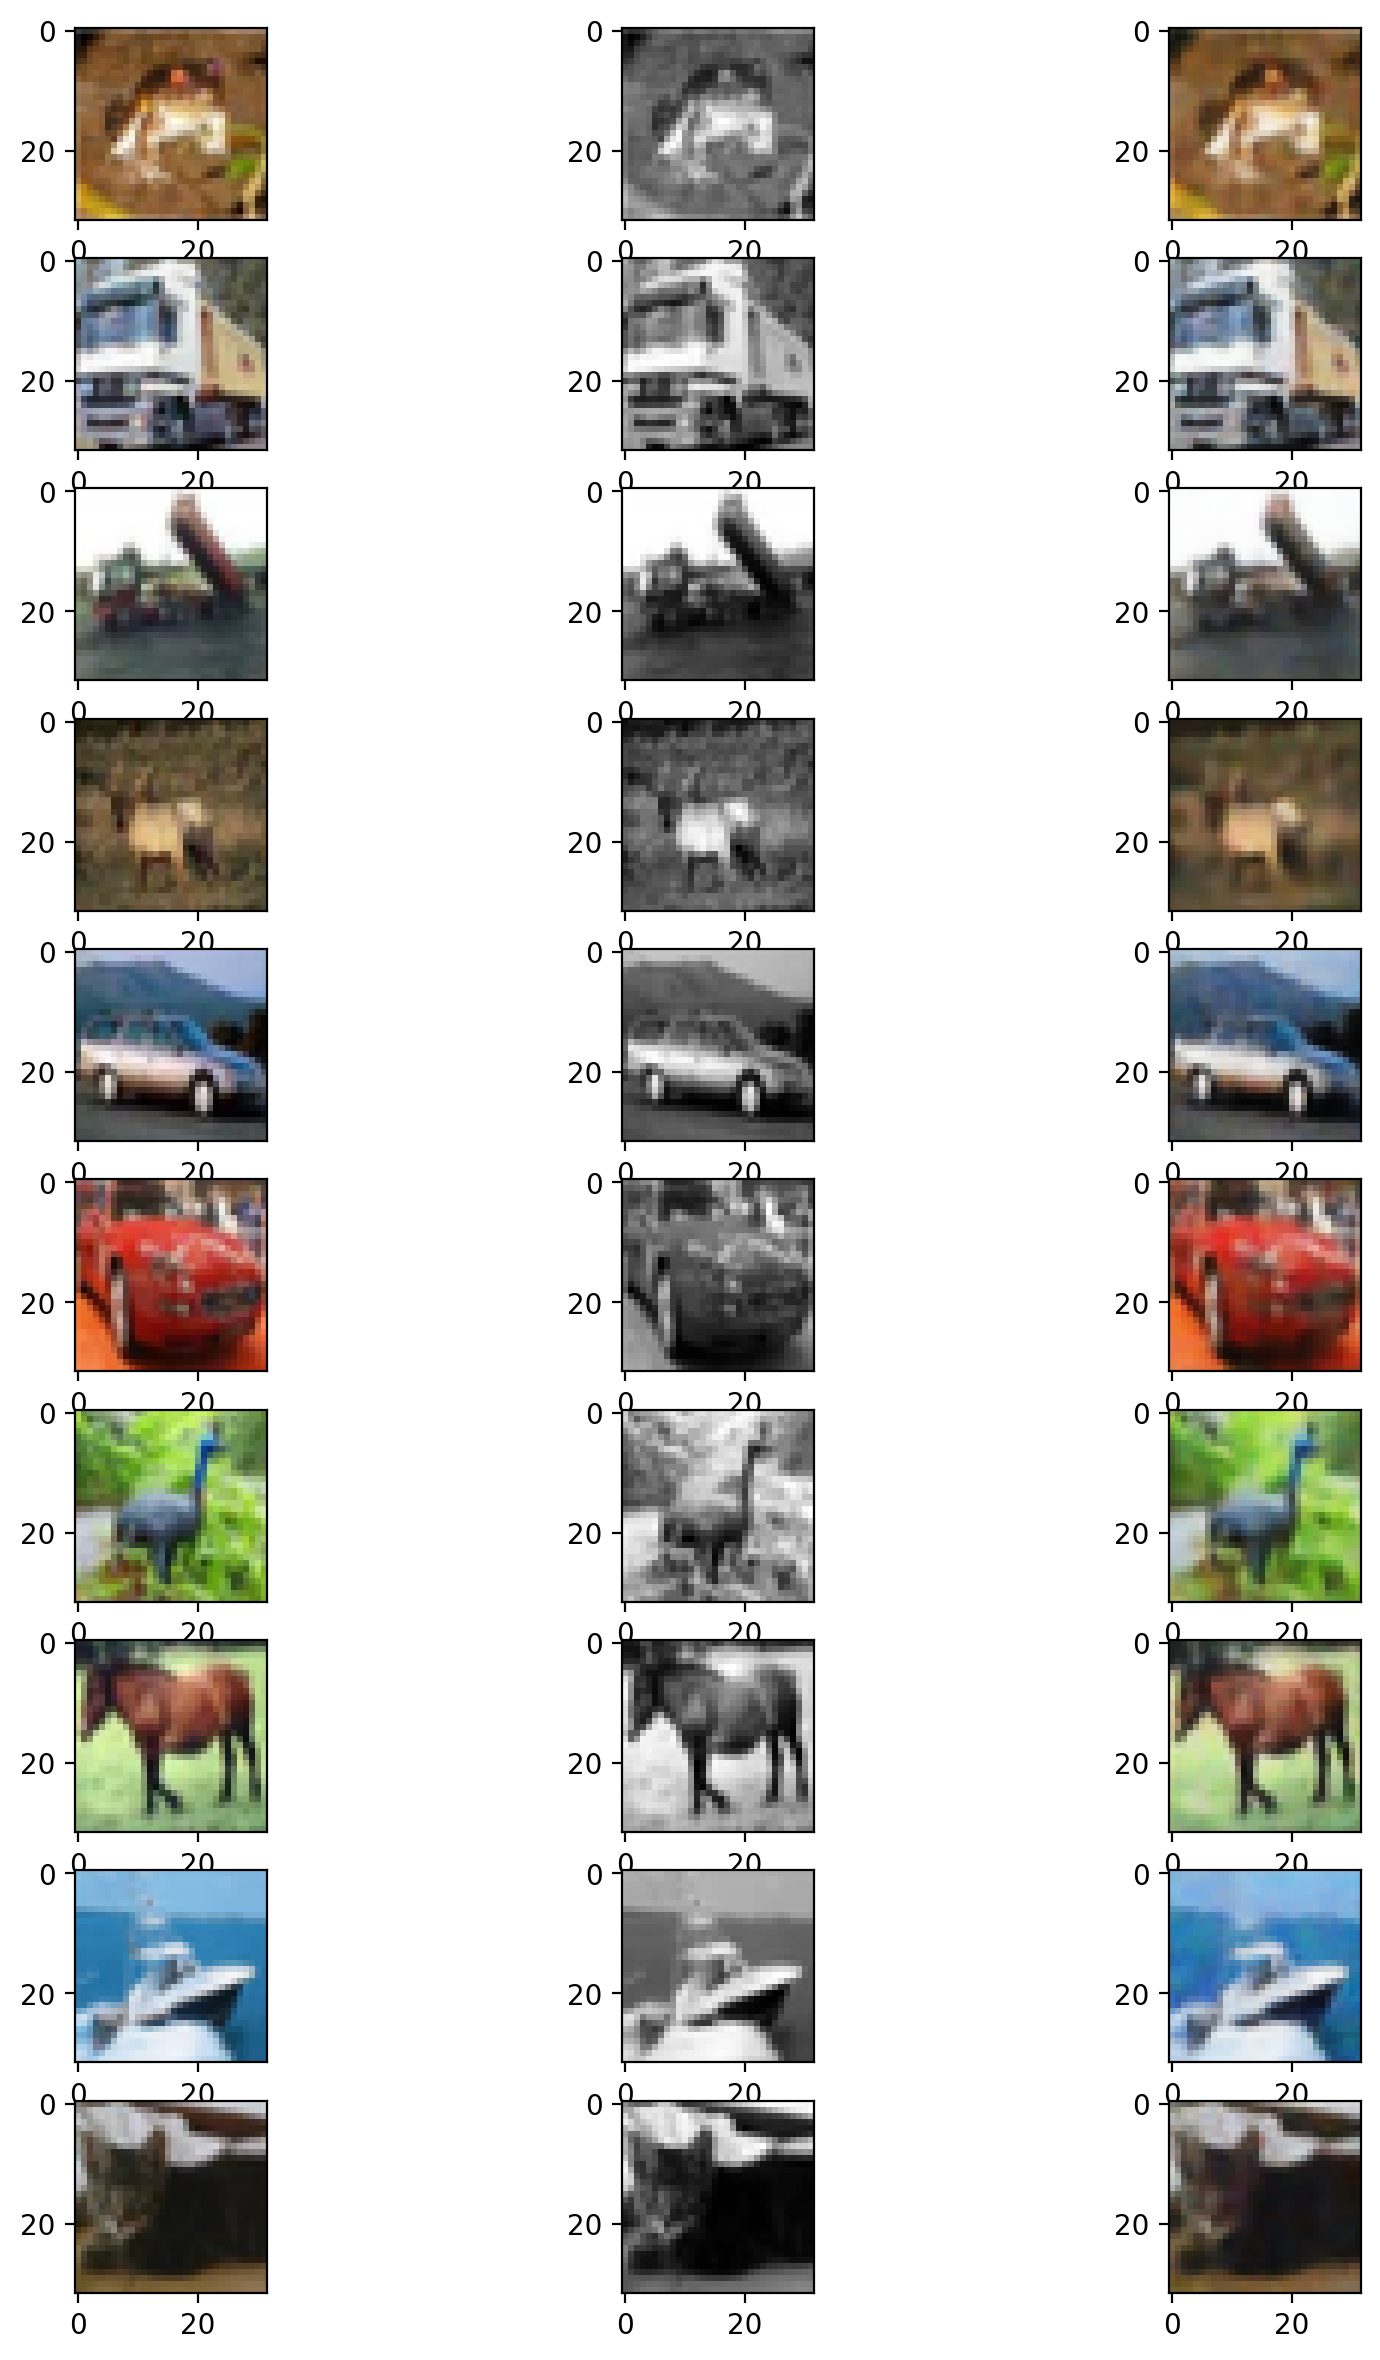

In [48]:
fig, axs = plt.subplots(10,3,figsize=(10,15))
for i in range(10):
    axs[i][0].imshow(x_train[i])
    axs[i][1].imshow(x_train_gray[i], cmap='gray')
    axs[i][2].imshow(model.predict(np.expand_dims(x_train_gray[i],0))[0])

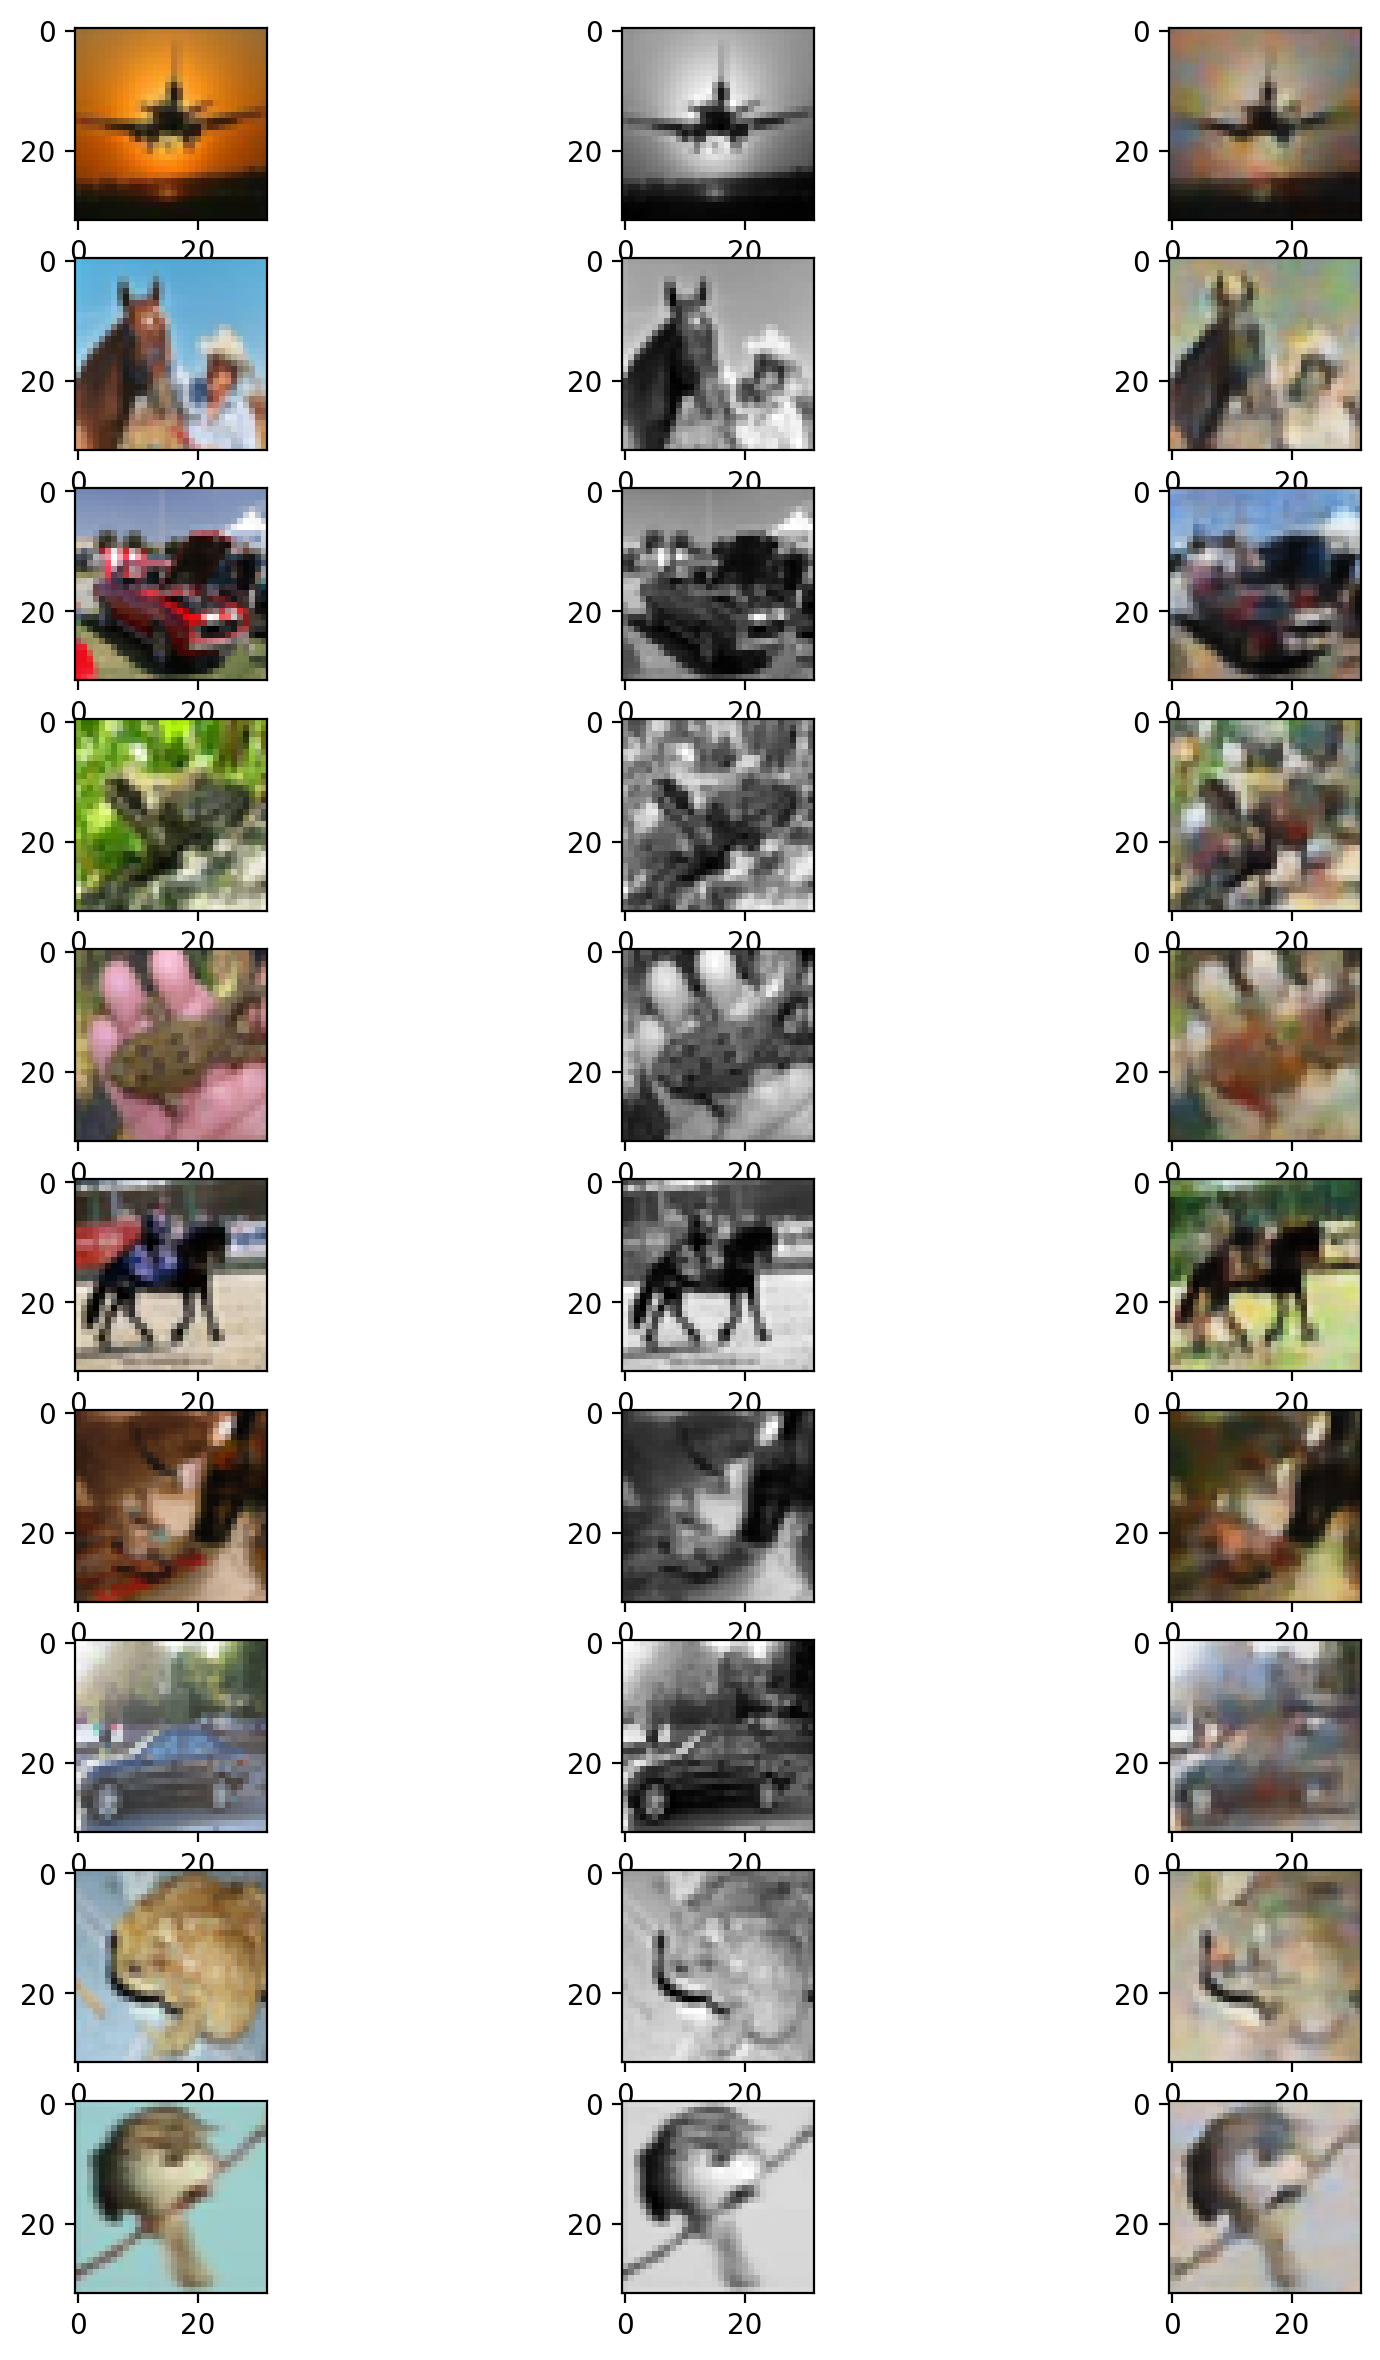

In [51]:
fig, axs = plt.subplots(10,3,figsize=(10,15))
for i, j in enumerate(np.random.randint(0, len(x_test), size=10)):
    axs[i][0].imshow(x_test[j])
    axs[i][1].imshow(x_test_gray[j], cmap='gray')
    axs[i][2].imshow(model.predict(np.expand_dims(x_test_gray[j],0))[0])

# Report

## Implementation

The implementation of the Convolutional Autoencoder model is encapsulated in the `buildModel()` function. As it can be seen from it's definition, the `buildModel()` can accept following optional arguments:

*   `activation_function` - activation function used in all layers except the last one, which always uses `sigmoid`
*    `padding, kernel_sizes, strides, dilation_rate` - define parameters for CNN operations
*   `encoder_filters, decoder_filters` - define number of layers and dimensions of these layers in the encoder and decoder parts of the model
*    `dense_latent_units` - allows to define the number and dimensions of dense fully connected latent layers in the botlleneck.
*    `conv_latent_channels` - allows to define the number and dimensions of convolutional latent layers in the botlleneck. Only dense OR conv could be used
*   `pooling_type, pooling_kernel` - allows to add max pooling layers to the CAE architecture
*    `input_channel_num` - defines the number of channels accepted at the input. `3` for RGB input image and `1` for grayscale.

## Experiments

Multiple experiments were conducted to research the behavior of CAE learning.

### Colorization - Grayscaling

The colorization task required to make accroding adjustments to the model constuction procedure, as variablity of input and grayscale conversion.

Initially the average grayscaling method was used for the conversion, but have shown low contrast images. After some research, the luminosity grayscaling method was chosen, which added some "visible" performance boost. The luminosity grayscaling method is a weighted average over the RGB channel values. The green is given more weight to account for human perception. The human vision is show to be more sensitive to green color. The luminosity grayscaling weights were adapted from the OpenCV implementation.

### Colorization - Using Fully Connected layer

The proposed network was implemented and tested and has shown acceptable results for the restoration task, but not for the colorization. After training that model, tests have shown that colorized images were on a brown-green border for almost whole picture and were not very representative.

Some research have shown that it is an usual practice  to use the dense layer between an encoder and a decoder. Therefore, the internal convolutional latent space was replaced by the fully connected dense layers bottleneck.

This have shown to significantly improve the performance of the CAE in the colorization task. The results can be seen from the Fig. 1. (will need to add it somewhere below).

The reason is that using purely convolutional layers have one major drawback. As the convolutional layers are used to represent one particular part of the input, they are not able to store the information about the full input. On the other hand, the fully connected layer can exactly solve that problem by being able to represent the input due to to presence of connections from all possible units in previous laywer. This is why the classification CNNs always use multiple FC layers at the output.
